<a href="https://colab.research.google.com/github/tvpian/Foundation_Models/blob/main/GenAI_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# visuallization function
def show(tensor, ch = 1, size  =(28,28), num = 16):
    data = tensor.detach().cpu().view(-1, ch, *size) # 128 x 784 -> 128 x 1 x 28 x 28
    grid = make_grid(data[:num], nrow = 4).permute(1,2,0) # 16 x 1 x 28 x 28
    plt.imshow(grid)
    plt.show()


In [ ]:
# Setup of the main parameters and the hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'
dataloader = DataLoader(MNIST('.', download = True, transform=transforms.ToTensor()), shuffle = True, batch_size = bs)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11748892.32it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 168309.94it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 828593.22it/s] 


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10214760.73it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# Declaration of the models
# Generater
def generator_block(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),# Results in a more stable training
      nn.ReLU(inplace = True) # Inplace = True helps in better memory management
  )

class Generator(nn.Module):
  def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(generator_block(z_dim, h_dim),
                              generator_block(h_dim, h_dim*2),
                              generator_block(h_dim*2, h_dim*4),
                              generator_block(h_dim*4, h_dim*8),
                              nn.Linear(h_dim*8, i_dim),
                              nn.Sigmoid(),
    )

  def forward(self, noise):
    return self.gen(noise)



# Discriminator
def discriminator_block(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2),
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim= 784, h_dim = 256):
    super().__init__()
    self.disc = nn.Sequential(
        discriminator_block(i_dim, h_dim*4),
        discriminator_block(h_dim*4, h_dim*2),
        discriminator_block(h_dim*2, h_dim),
        nn.Linear(h_dim, 1)
    )

  def forward(self, image):
    return self.disc(image)


def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([3, 9, 8, 2, 3, 5, 0, 8, 0, 2])


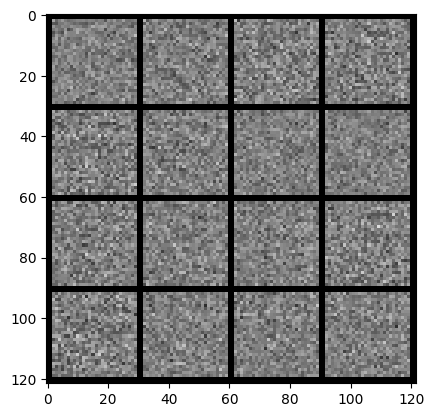

In [ ]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# Calculating the loss
# generator loss

def calc_gen_loss(loss_func, gen, disc, number, z_diom):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)
  return gen_loss

def calc_disc_loss(loss_fun, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)
  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)
  disc_loss = ((disc_fake_loss + disc_real_loss)/2)
  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

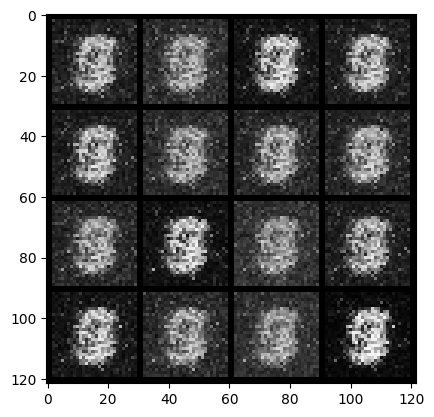

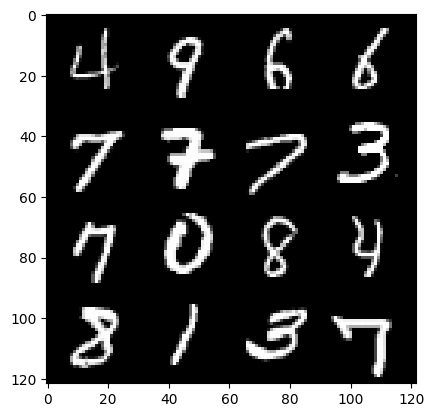

0: step 300/ Generator Loss: 1.8558715460697812 / disc_loss: 0.32845844912032307


  0%|          | 0/469 [00:00<?, ?it/s]

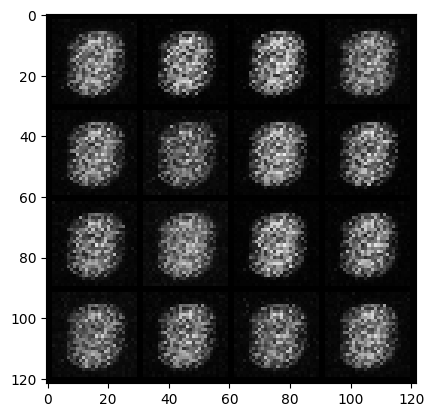

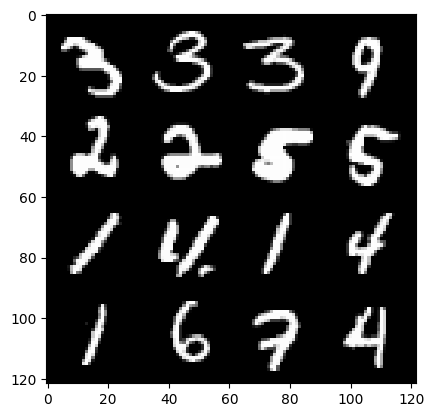

1: step 600/ Generator Loss: 3.4202493047714224 / disc_loss: 0.11157941227157911


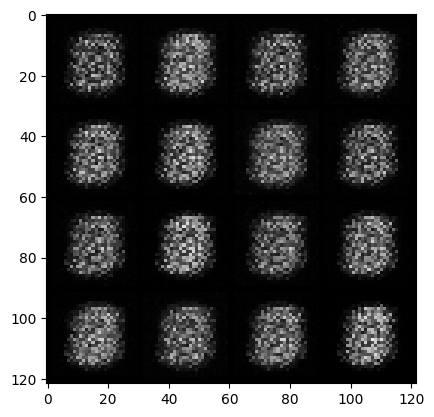

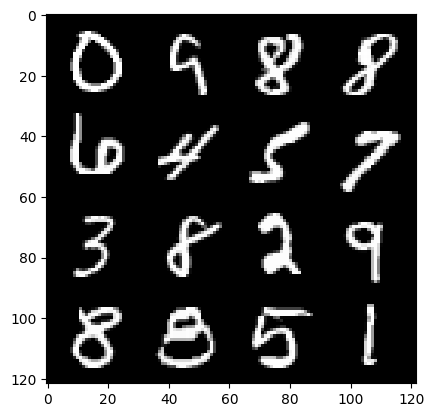

1: step 900/ Generator Loss: 3.3337364141146346 / disc_loss: 0.05954278524965053


  0%|          | 0/469 [00:00<?, ?it/s]

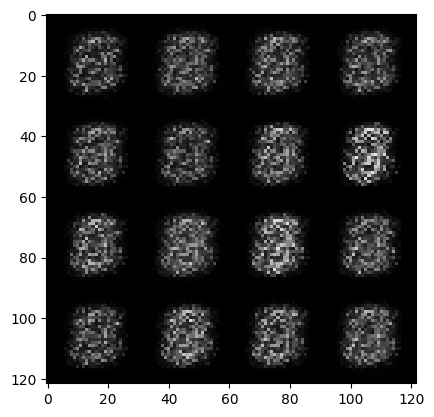

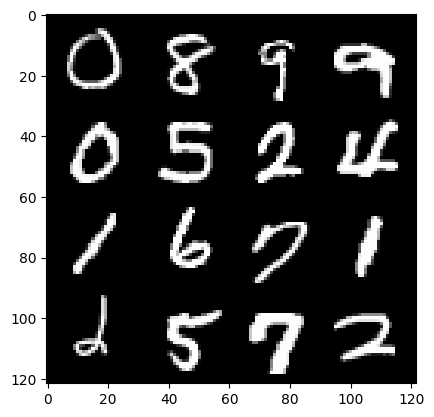

2: step 1200/ Generator Loss: 3.404028646151227 / disc_loss: 0.040966742963840584


  0%|          | 0/469 [00:00<?, ?it/s]

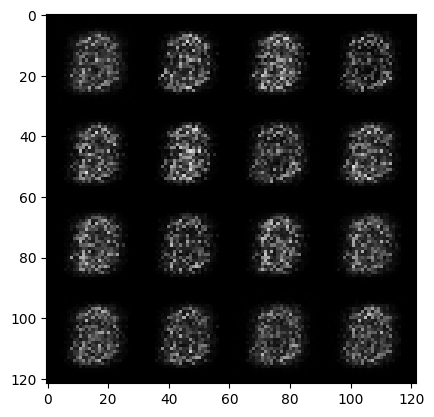

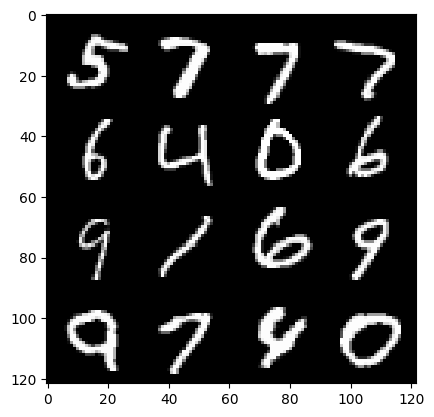

3: step 1500/ Generator Loss: 3.4304632027943898 / disc_loss: 0.04029555858423311


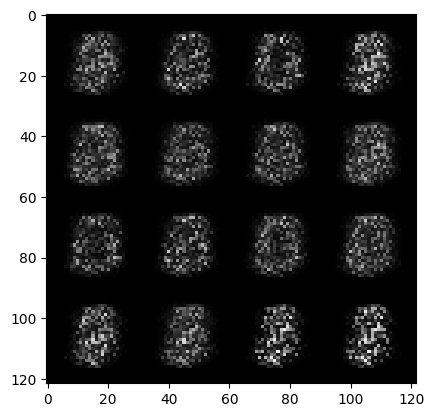

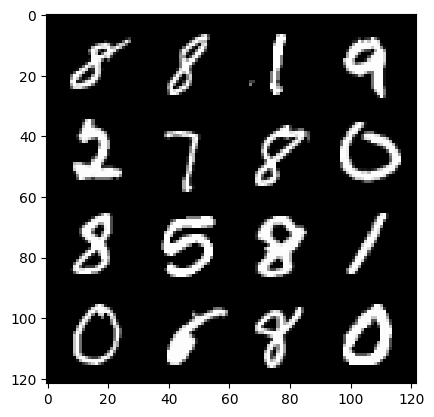

3: step 1800/ Generator Loss: 3.6112813886006667 / disc_loss: 0.03838387144729496


  0%|          | 0/469 [00:00<?, ?it/s]

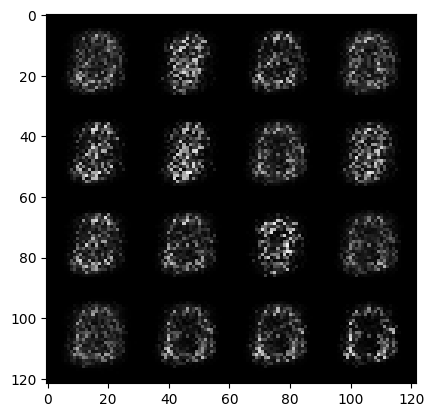

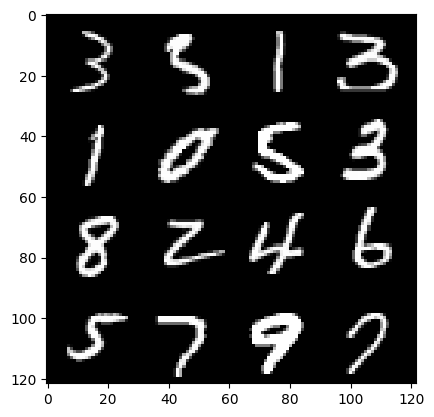

4: step 2100/ Generator Loss: 3.9172930129369083 / disc_loss: 0.033933149936298534


  0%|          | 0/469 [00:00<?, ?it/s]

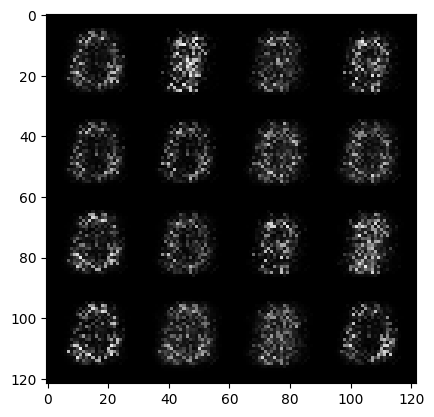

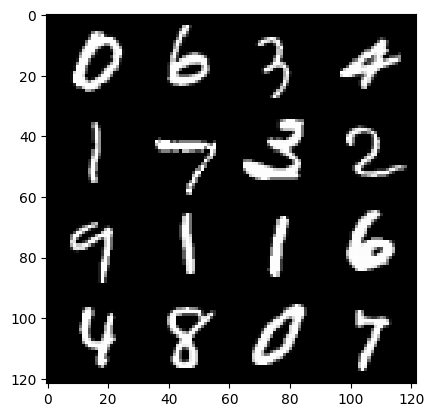

5: step 2400/ Generator Loss: 4.300545473098759 / disc_loss: 0.029002885421117154


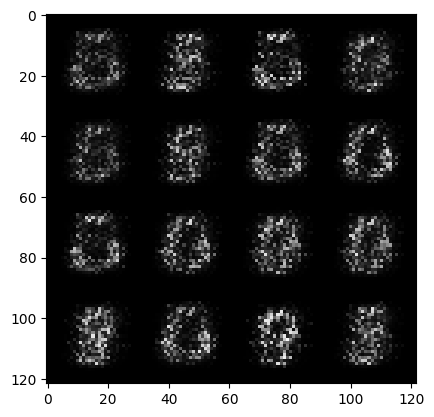

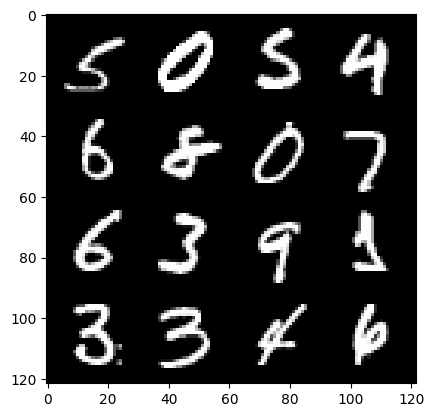

5: step 2700/ Generator Loss: 4.602180460294089 / disc_loss: 0.020544930494700867


  0%|          | 0/469 [00:00<?, ?it/s]

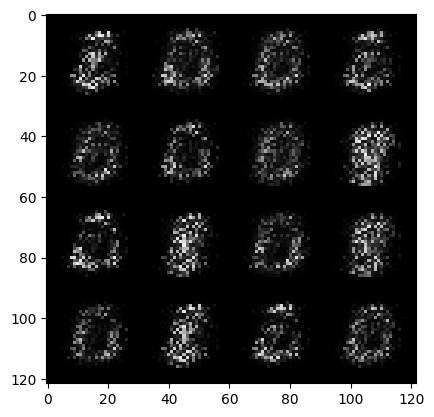

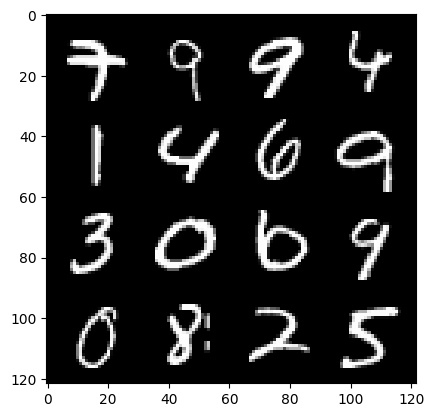

6: step 3000/ Generator Loss: 4.982705841064454 / disc_loss: 0.015542644048109655


  0%|          | 0/469 [00:00<?, ?it/s]

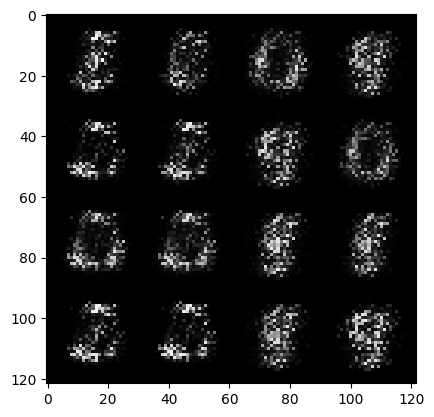

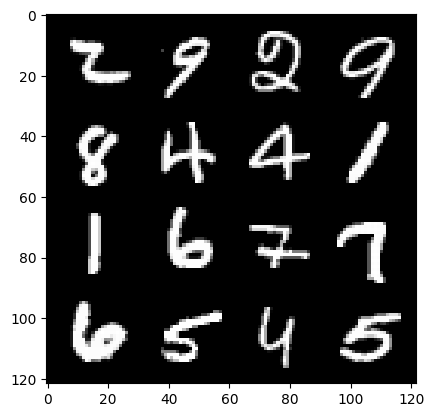

7: step 3300/ Generator Loss: 5.646399753888451 / disc_loss: 0.011885721317181987


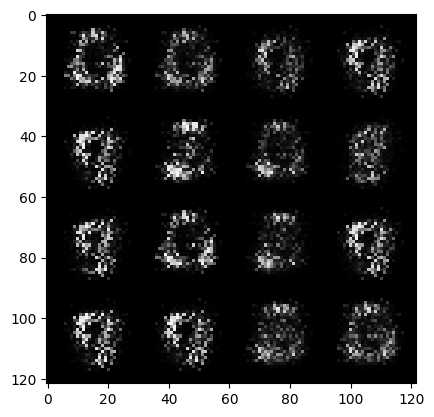

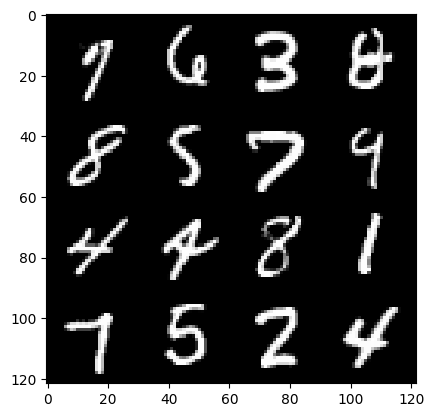

7: step 3600/ Generator Loss: 5.731147837638857 / disc_loss: 0.011003924294685325


  0%|          | 0/469 [00:00<?, ?it/s]

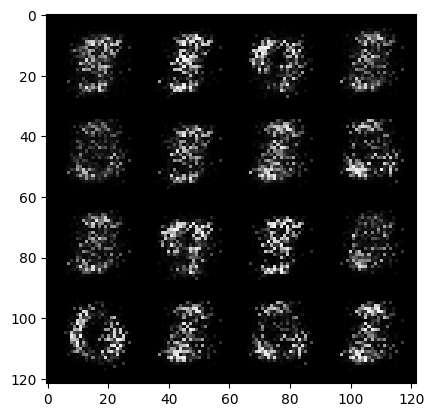

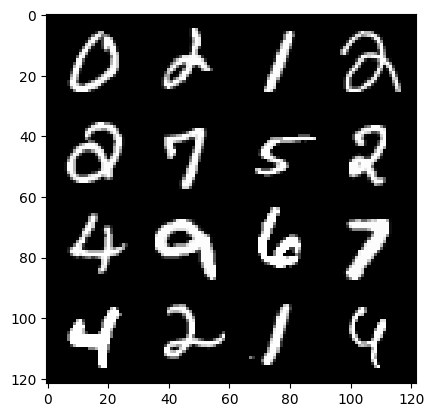

8: step 3900/ Generator Loss: 5.730033822059634 / disc_loss: 0.011138538687179487


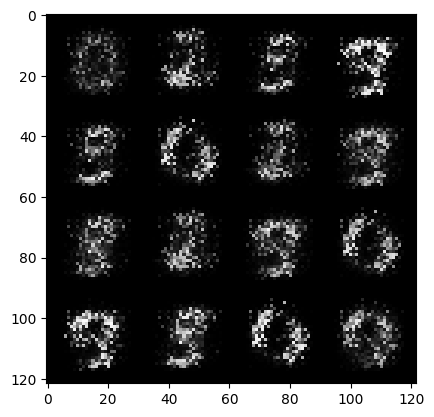

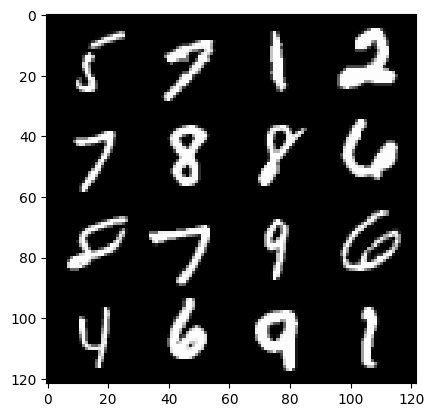

8: step 4200/ Generator Loss: 6.162754600842798 / disc_loss: 0.010707320487126708


  0%|          | 0/469 [00:00<?, ?it/s]

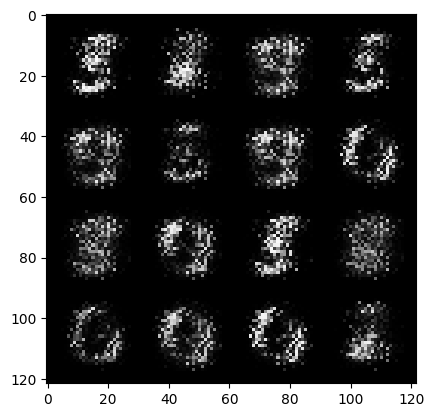

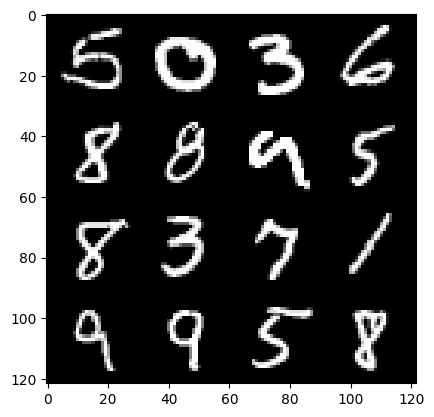

9: step 4500/ Generator Loss: 6.318137181599932 / disc_loss: 0.010782563717414931


  0%|          | 0/469 [00:00<?, ?it/s]

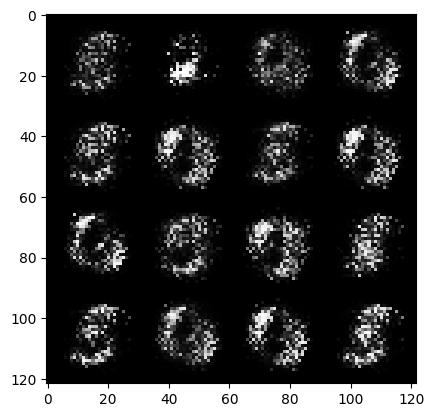

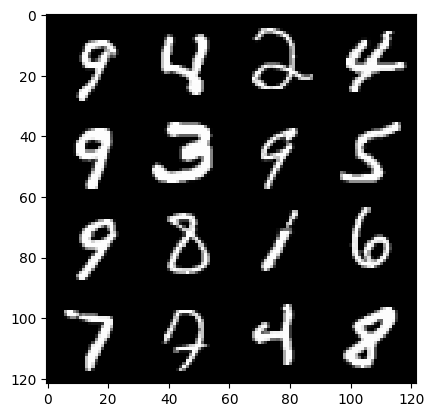

10: step 4800/ Generator Loss: 6.69188034057617 / disc_loss: 0.009301496138796205


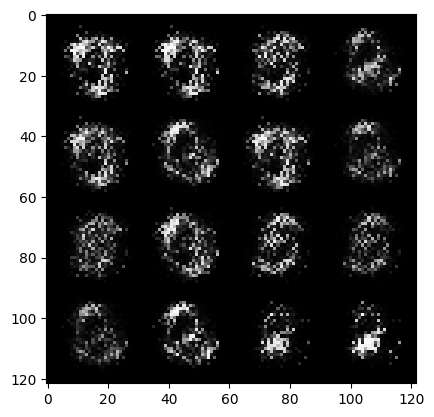

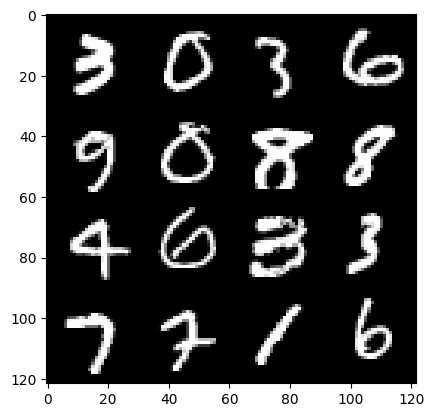

10: step 5100/ Generator Loss: 6.710132055282599 / disc_loss: 0.011562968303915113


  0%|          | 0/469 [00:00<?, ?it/s]

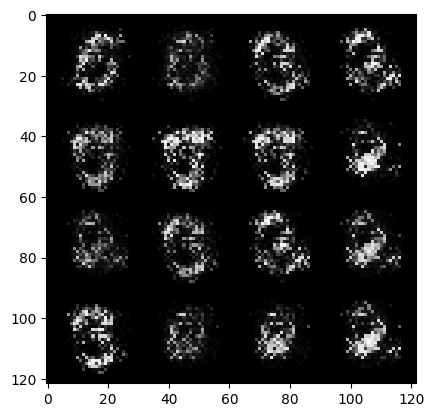

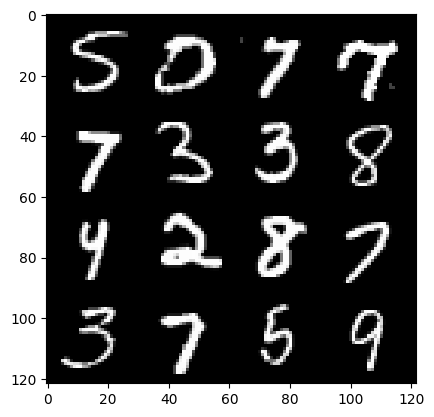

11: step 5400/ Generator Loss: 6.7140297063191685 / disc_loss: 0.010413652725983411


  0%|          | 0/469 [00:00<?, ?it/s]

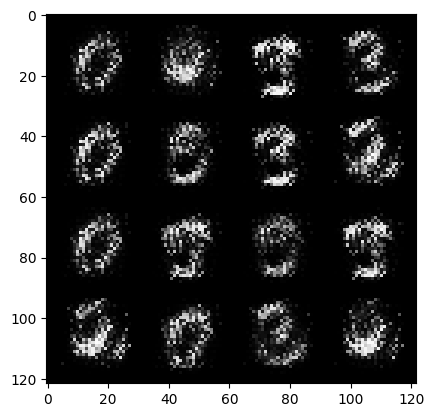

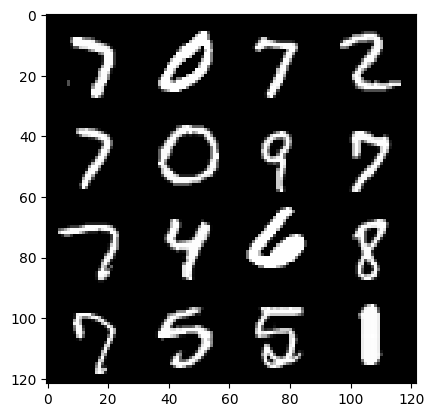

12: step 5700/ Generator Loss: 6.539303816159566 / disc_loss: 0.01240652450049916


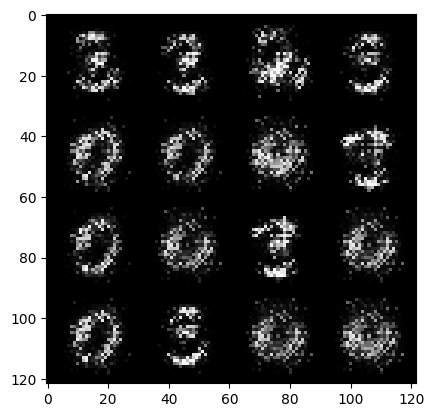

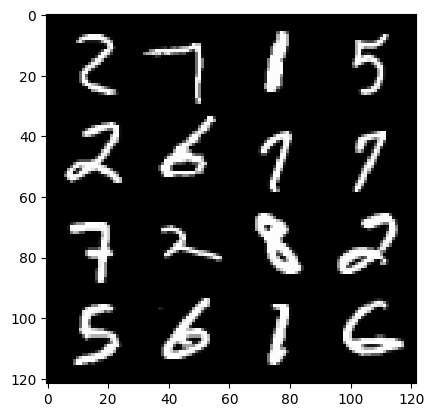

12: step 6000/ Generator Loss: 6.4299429146448785 / disc_loss: 0.010973306434849894


  0%|          | 0/469 [00:00<?, ?it/s]

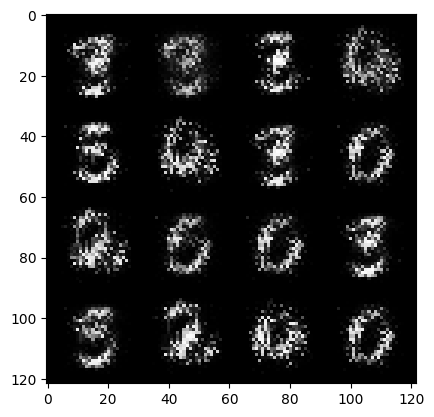

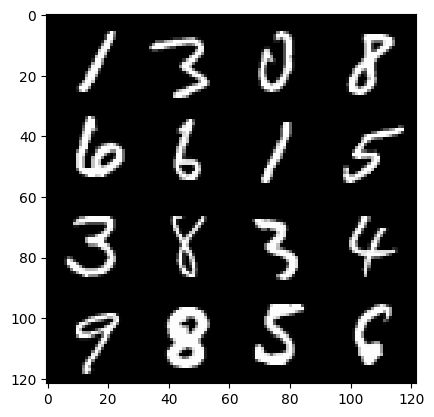

13: step 6300/ Generator Loss: 6.696514128049218 / disc_loss: 0.008973866026693332


  0%|          | 0/469 [00:00<?, ?it/s]

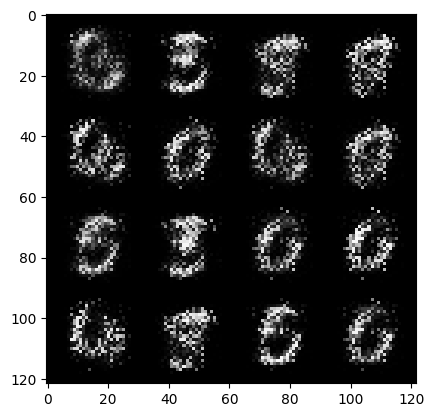

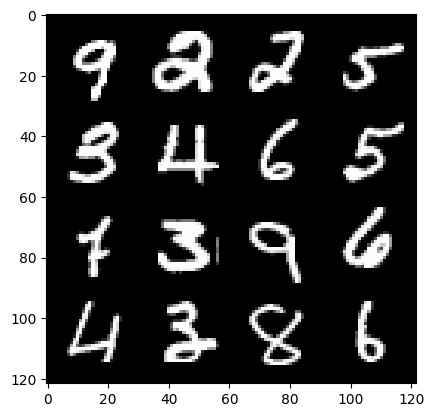

14: step 6600/ Generator Loss: 6.906241577466328 / disc_loss: 0.007873031704220917


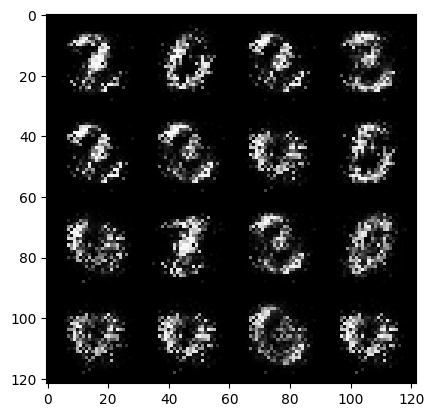

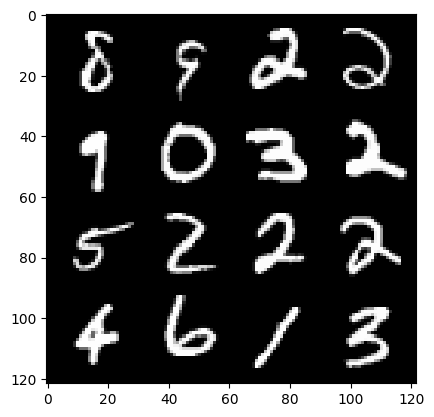

14: step 6900/ Generator Loss: 7.0705787785848 / disc_loss: 0.007623319139238448


  0%|          | 0/469 [00:00<?, ?it/s]

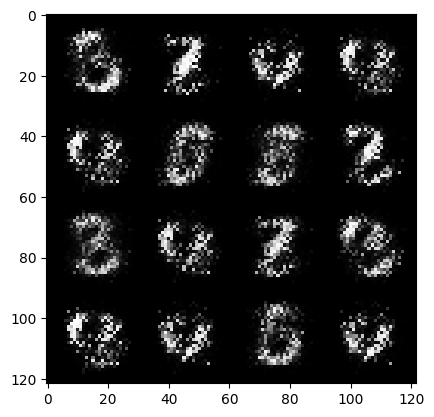

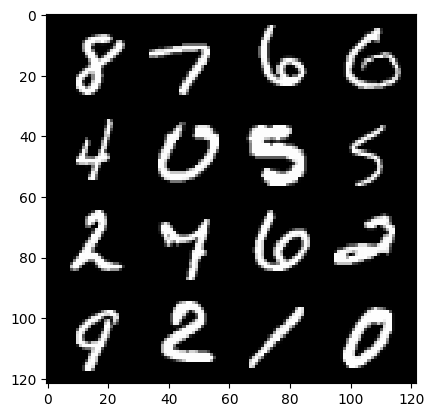

15: step 7200/ Generator Loss: 7.474496499697367 / disc_loss: 0.007112527746357956


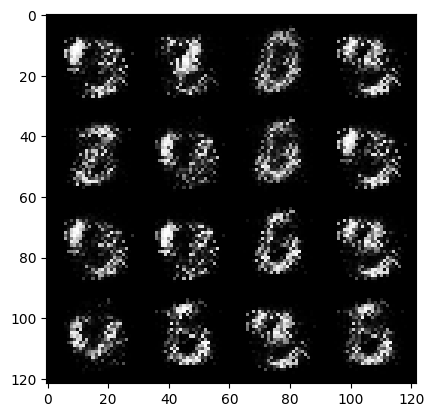

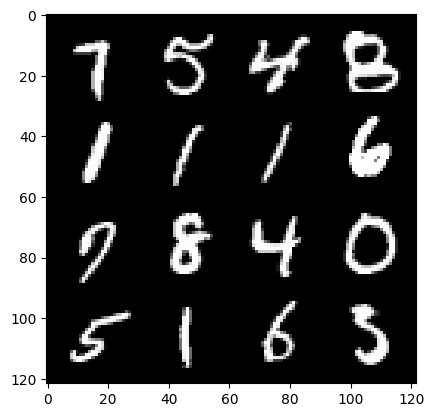

15: step 7500/ Generator Loss: 7.486447347005207 / disc_loss: 0.009285224560104917


  0%|          | 0/469 [00:00<?, ?it/s]

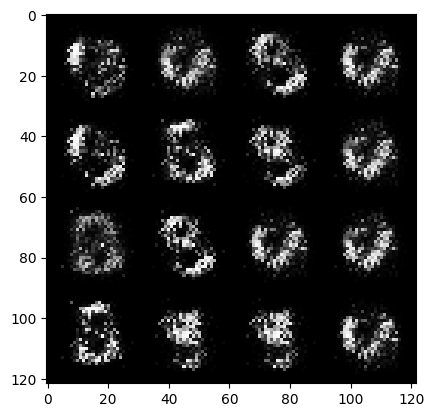

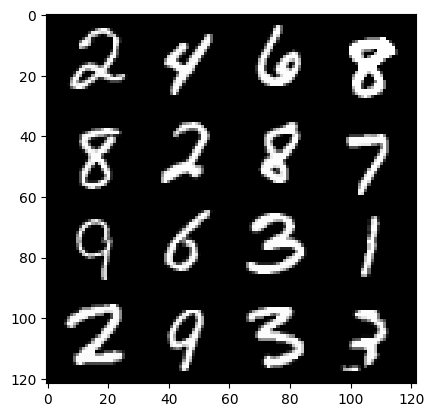

16: step 7800/ Generator Loss: 7.148644639650984 / disc_loss: 0.010921614026495571


  0%|          | 0/469 [00:00<?, ?it/s]

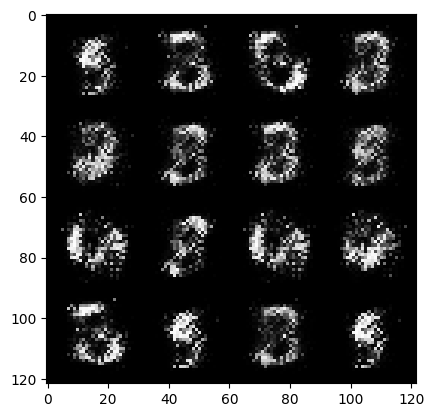

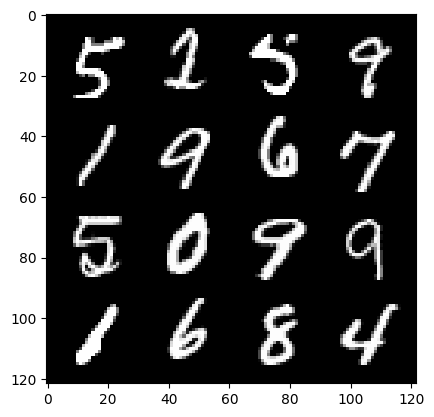

17: step 8100/ Generator Loss: 7.788588638305666 / disc_loss: 0.011557618728062756


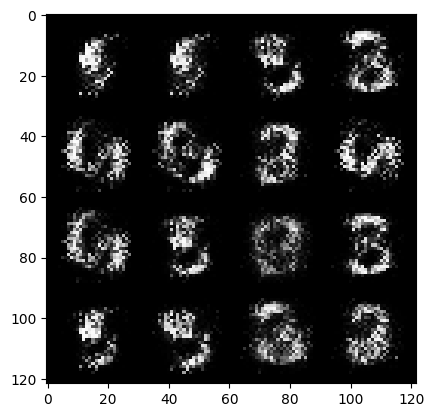

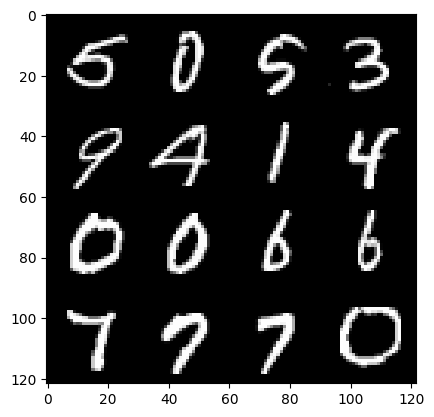

17: step 8400/ Generator Loss: 6.967737897237138 / disc_loss: 0.010957942088910693


  0%|          | 0/469 [00:00<?, ?it/s]

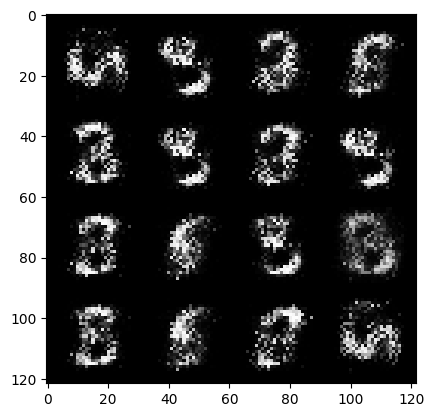

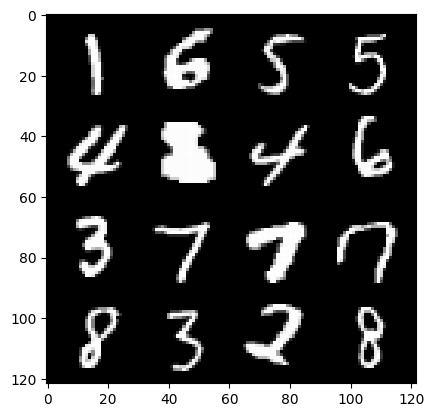

18: step 8700/ Generator Loss: 6.738633047739667 / disc_loss: 0.011669731504516683


  0%|          | 0/469 [00:00<?, ?it/s]

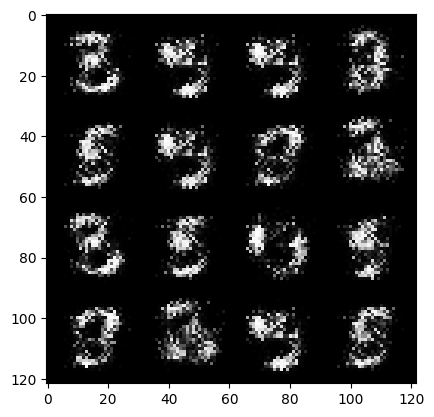

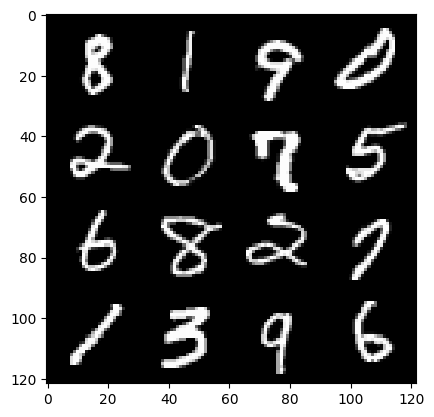

19: step 9000/ Generator Loss: 6.596882853507999 / disc_loss: 0.008510972911802432


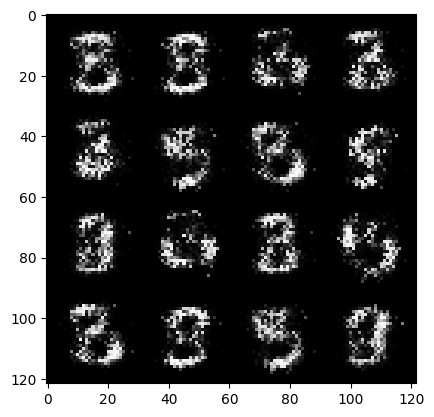

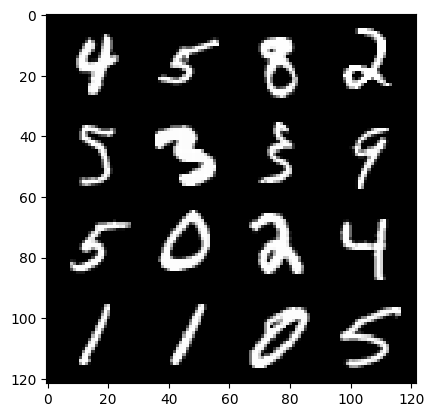

19: step 9300/ Generator Loss: 6.698199191093444 / disc_loss: 0.0074070562752119


  0%|          | 0/469 [00:00<?, ?it/s]

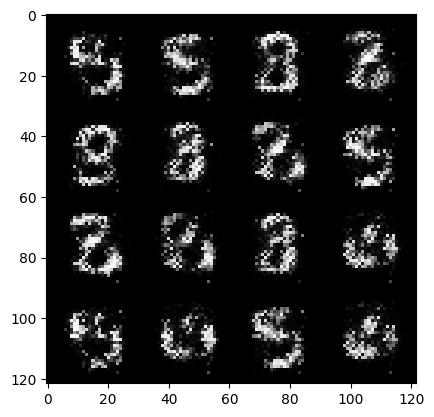

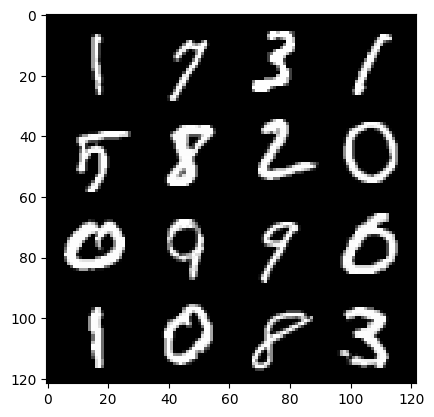

20: step 9600/ Generator Loss: 6.830846991539002 / disc_loss: 0.007951516468310731


  0%|          | 0/469 [00:00<?, ?it/s]

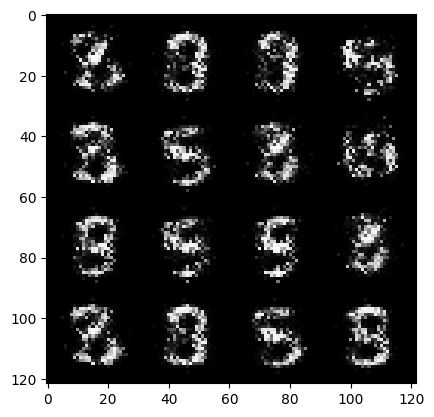

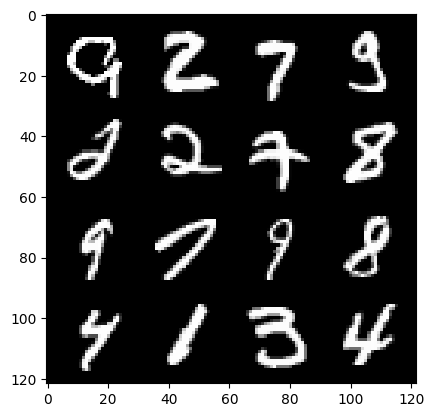

21: step 9900/ Generator Loss: 6.363265004158017 / disc_loss: 0.010193474993187313


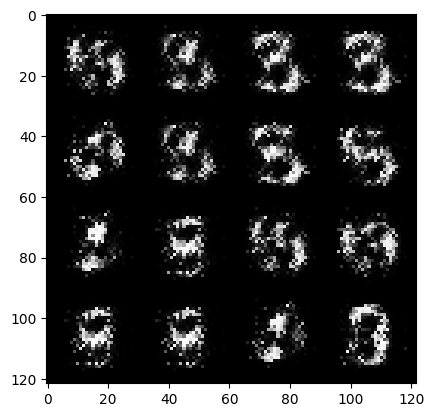

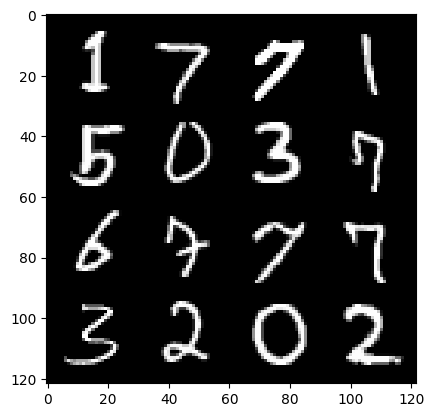

21: step 10200/ Generator Loss: 6.886894720395406 / disc_loss: 0.009232430371145402


  0%|          | 0/469 [00:00<?, ?it/s]

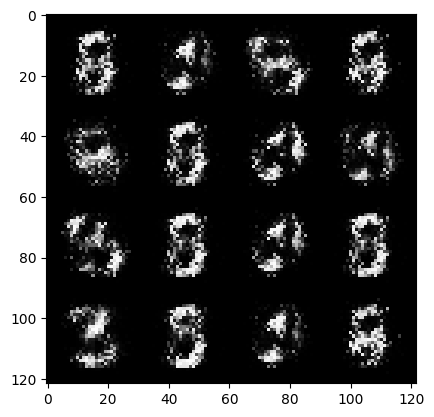

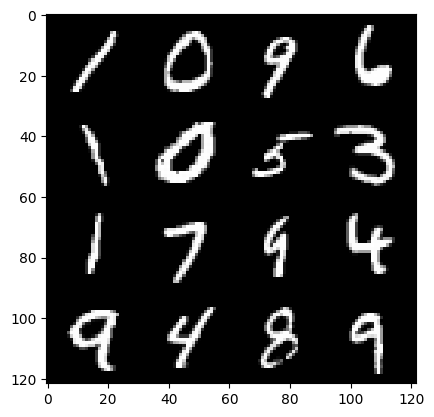

22: step 10500/ Generator Loss: 7.308824342091875 / disc_loss: 0.009447896823985504


  0%|          | 0/469 [00:00<?, ?it/s]

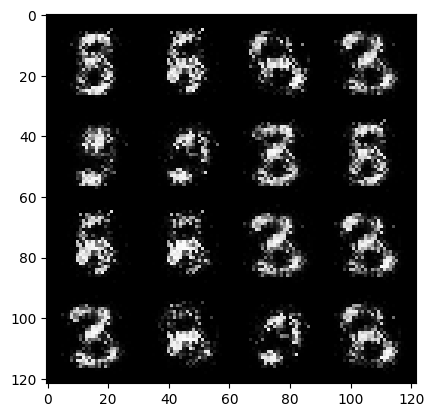

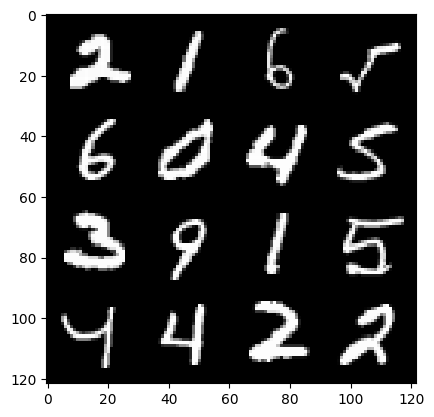

23: step 10800/ Generator Loss: 6.880853970845544 / disc_loss: 0.010219796439632776


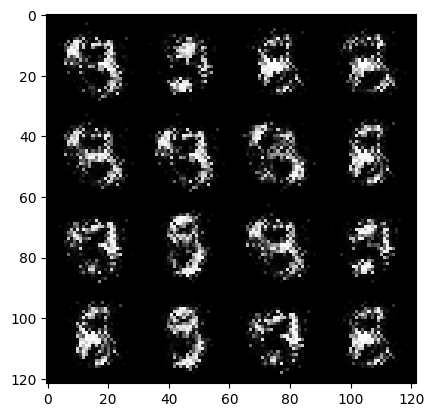

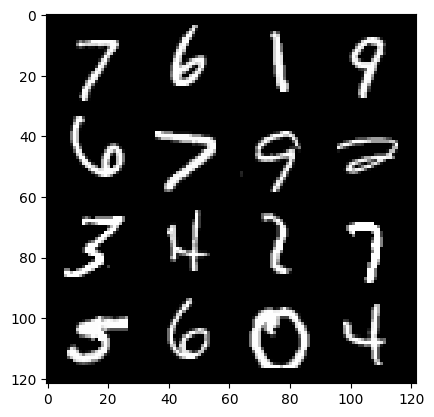

23: step 11100/ Generator Loss: 6.672274683316553 / disc_loss: 0.009466845747859528


  0%|          | 0/469 [00:00<?, ?it/s]

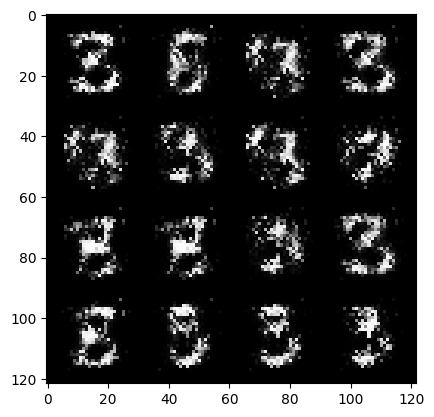

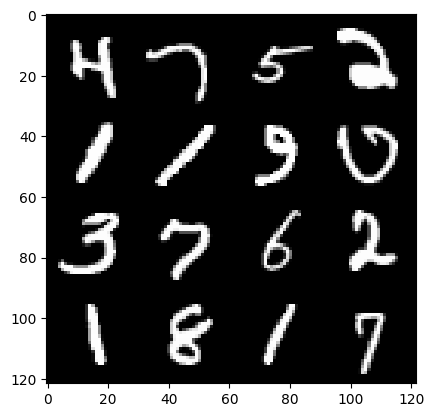

24: step 11400/ Generator Loss: 7.108601876894636 / disc_loss: 0.007965659099281769


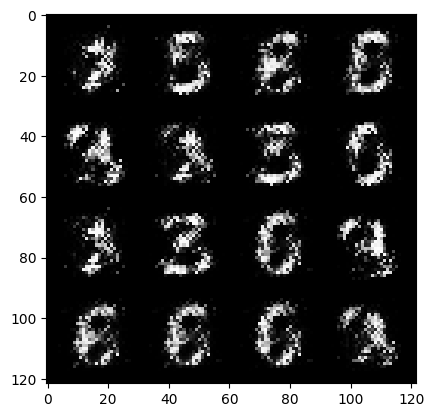

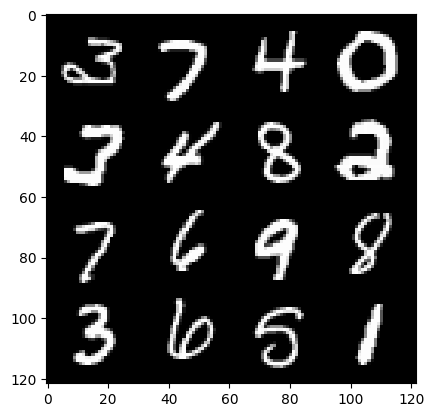

24: step 11700/ Generator Loss: 6.827398843765261 / disc_loss: 0.007653198531091525


  0%|          | 0/469 [00:00<?, ?it/s]

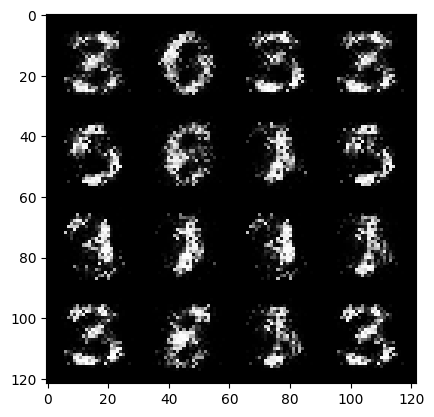

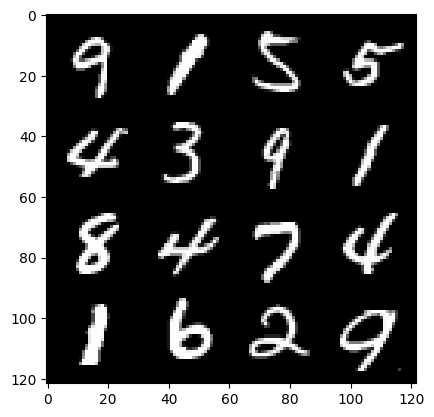

25: step 12000/ Generator Loss: 7.127046542167665 / disc_loss: 0.008862657463566083


  0%|          | 0/469 [00:00<?, ?it/s]

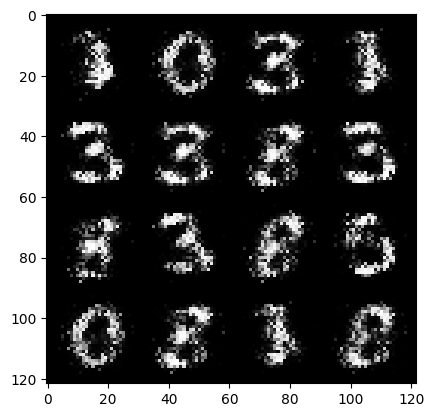

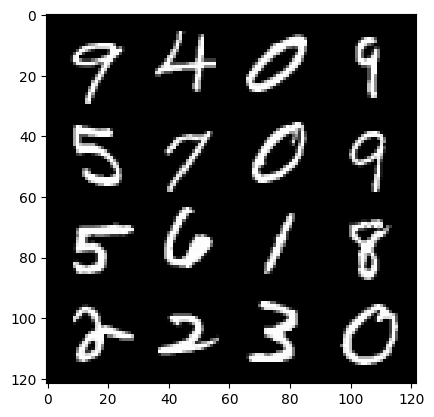

26: step 12300/ Generator Loss: 6.98086657524109 / disc_loss: 0.009113267240269729


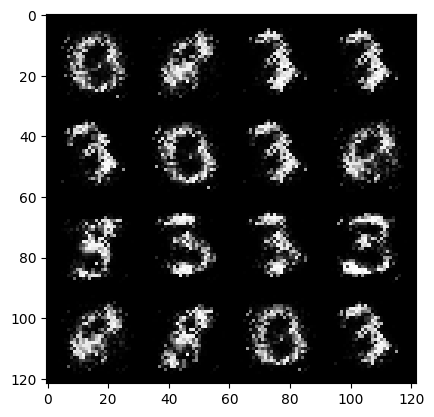

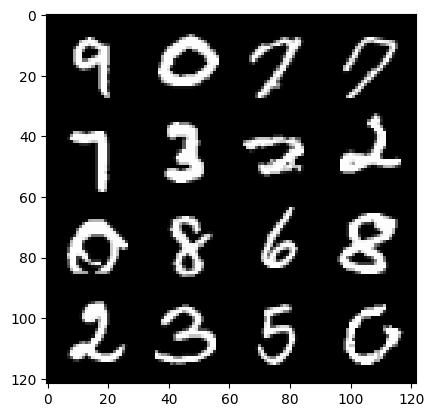

26: step 12600/ Generator Loss: 6.971388864517211 / disc_loss: 0.01120568752133598


  0%|          | 0/469 [00:00<?, ?it/s]

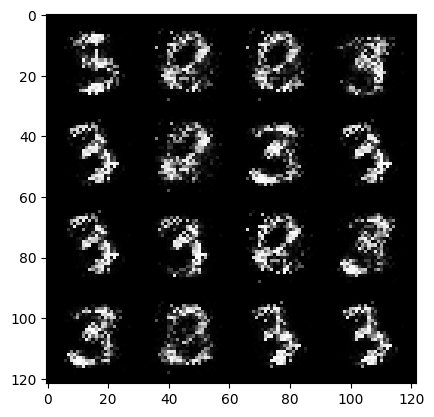

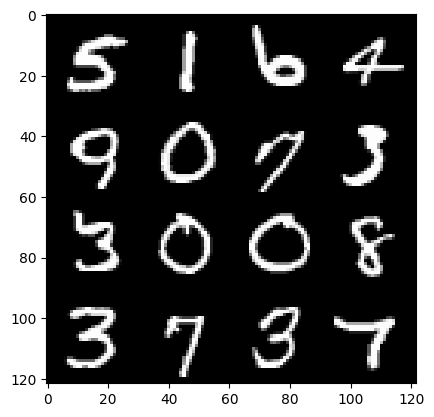

27: step 12900/ Generator Loss: 6.8491561555862495 / disc_loss: 0.009210935210188231


  0%|          | 0/469 [00:00<?, ?it/s]

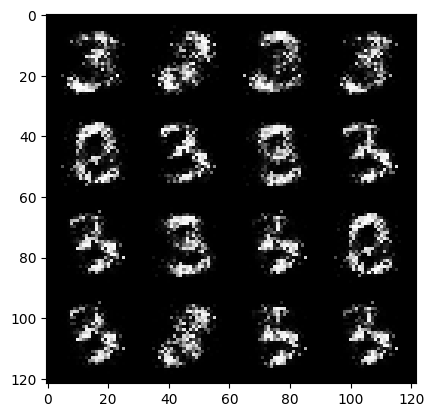

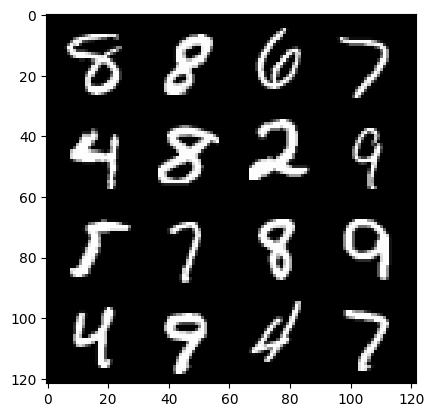

28: step 13200/ Generator Loss: 6.923529725074769 / disc_loss: 0.009965341273151955


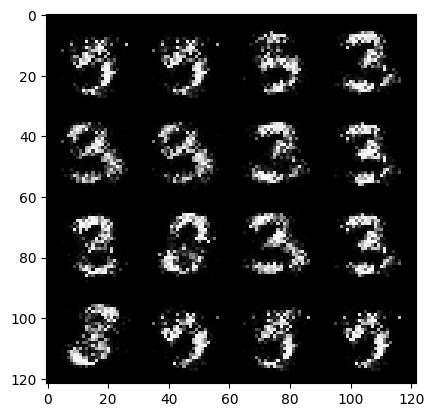

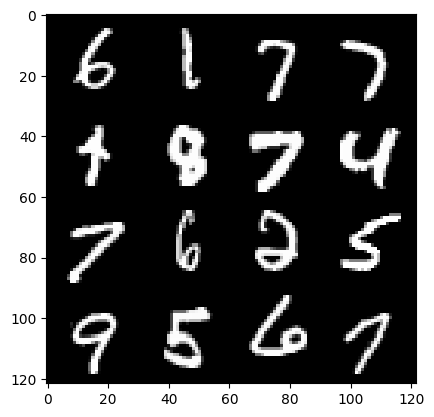

28: step 13500/ Generator Loss: 7.109537583986912 / disc_loss: 0.009493122341615765


  0%|          | 0/469 [00:00<?, ?it/s]

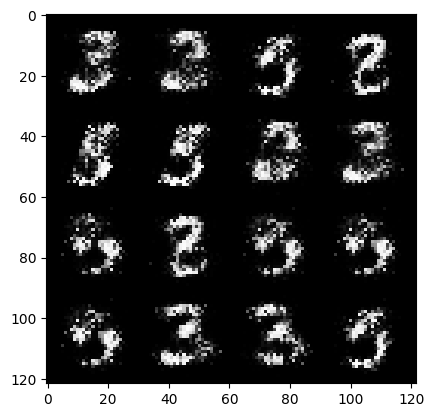

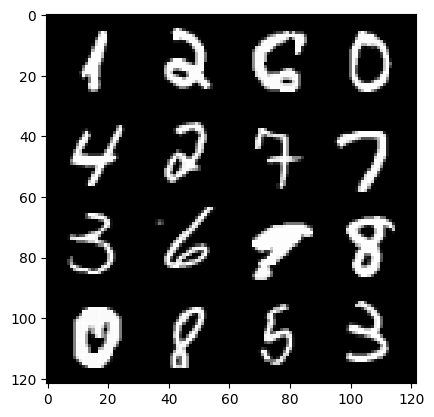

29: step 13800/ Generator Loss: 7.04434703509012 / disc_loss: 0.010272716382363186


  0%|          | 0/469 [00:00<?, ?it/s]

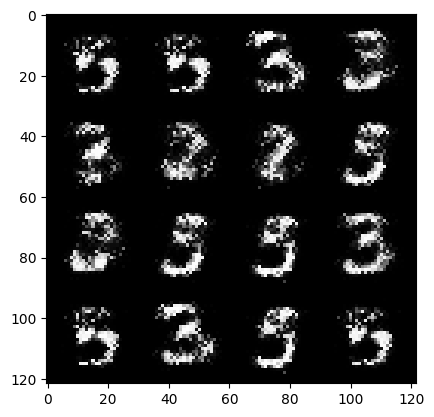

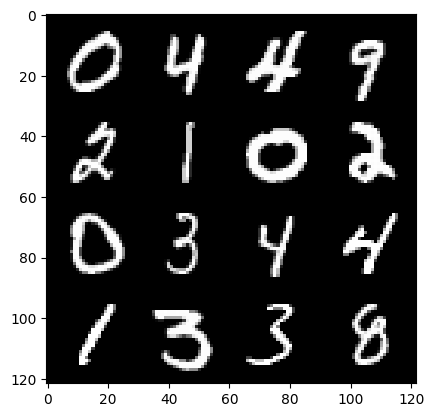

30: step 14100/ Generator Loss: 6.7647298320134475 / disc_loss: 0.011584321807992334


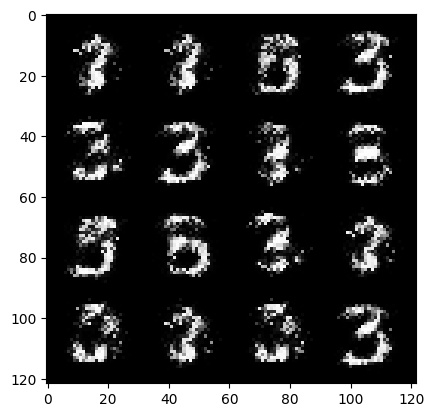

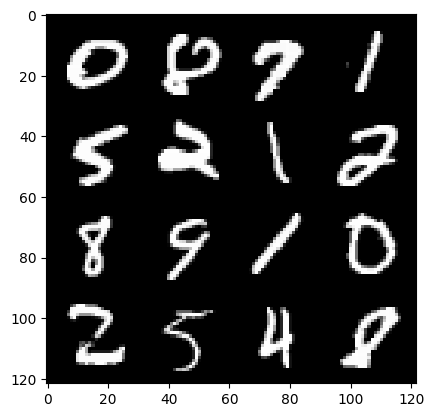

30: step 14400/ Generator Loss: 6.533431841532392 / disc_loss: 0.011183540897521502


  0%|          | 0/469 [00:00<?, ?it/s]

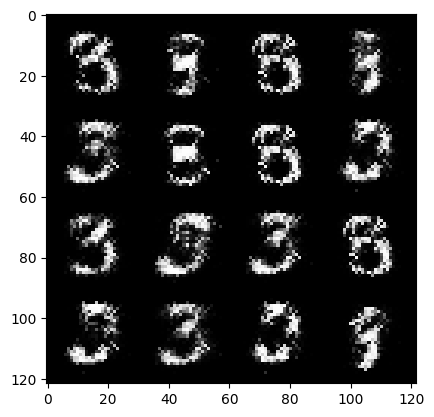

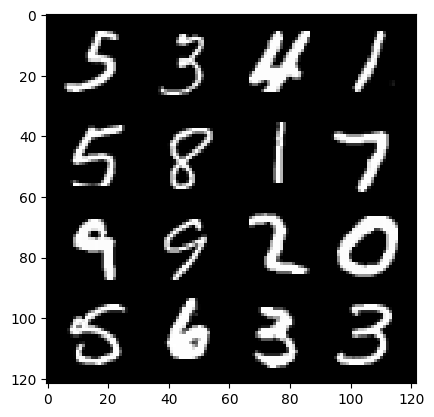

31: step 14700/ Generator Loss: 6.673818278312685 / disc_loss: 0.010788869608659298


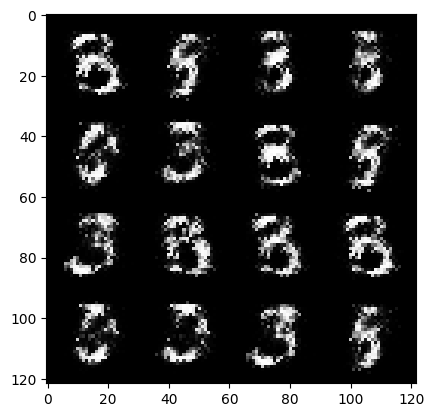

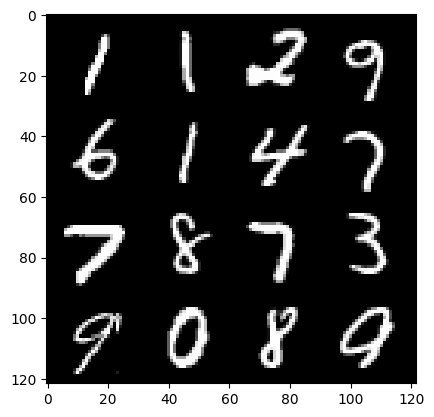

31: step 15000/ Generator Loss: 6.70714180151621 / disc_loss: 0.011996897753948963


  0%|          | 0/469 [00:00<?, ?it/s]

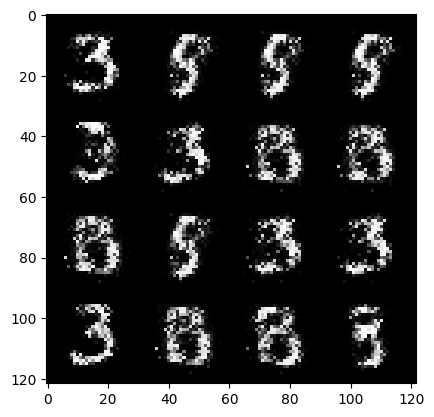

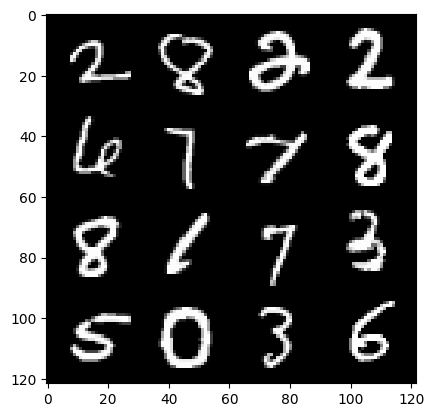

32: step 15300/ Generator Loss: 6.3928190565109295 / disc_loss: 0.011136414941477907


  0%|          | 0/469 [00:00<?, ?it/s]

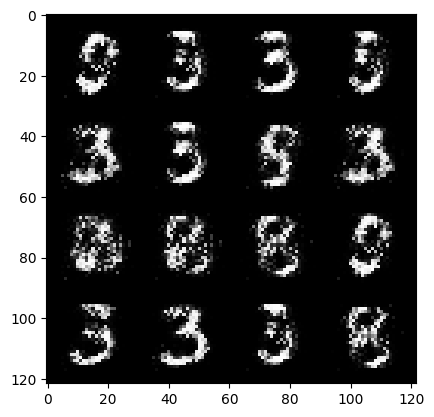

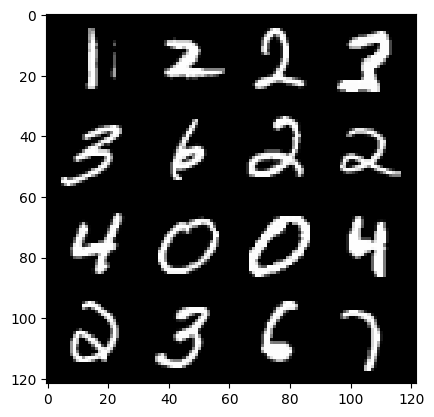

33: step 15600/ Generator Loss: 6.730967775980635 / disc_loss: 0.009387965242688858


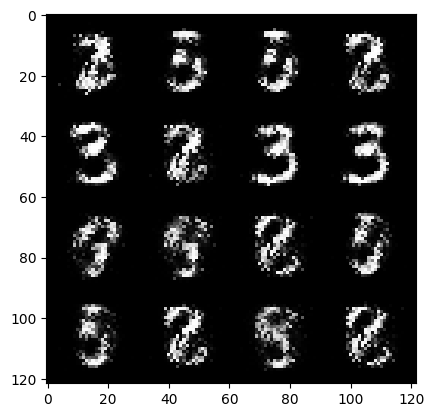

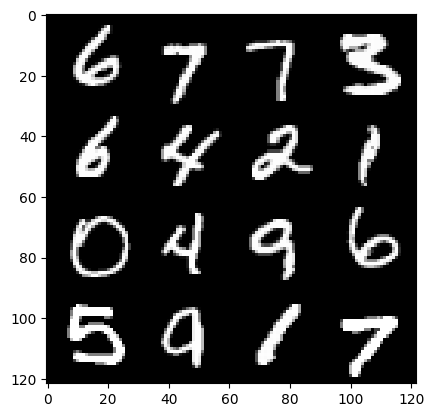

33: step 15900/ Generator Loss: 6.799693128267924 / disc_loss: 0.013126189127409212


  0%|          | 0/469 [00:00<?, ?it/s]

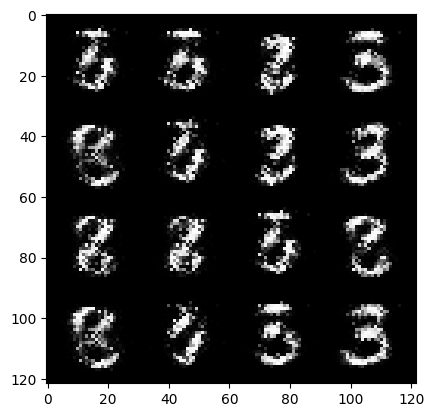

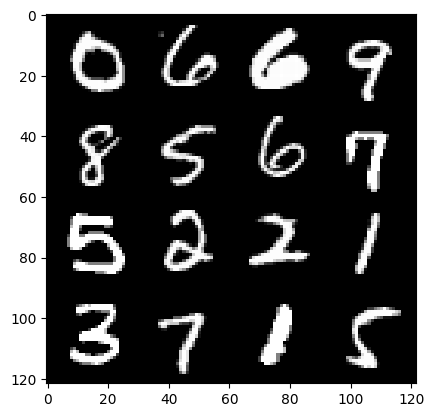

34: step 16200/ Generator Loss: 6.428704001108806 / disc_loss: 0.015206776360282661


  0%|          | 0/469 [00:00<?, ?it/s]

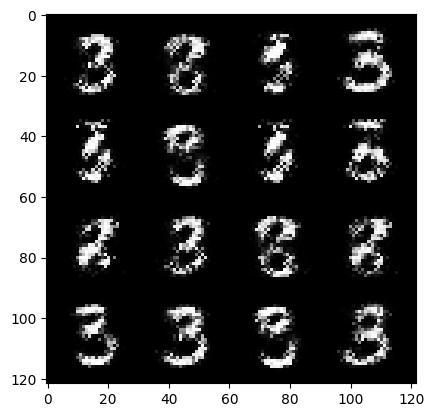

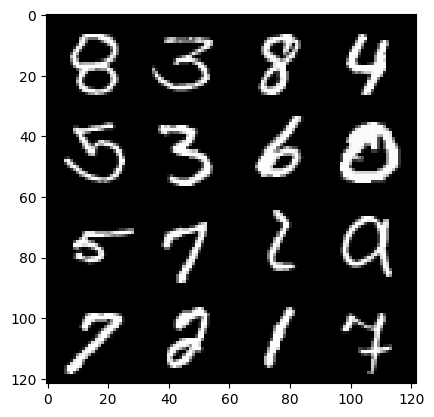

35: step 16500/ Generator Loss: 6.465375765164697 / disc_loss: 0.016496875193746156


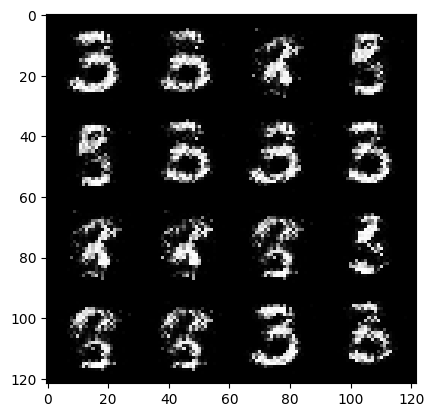

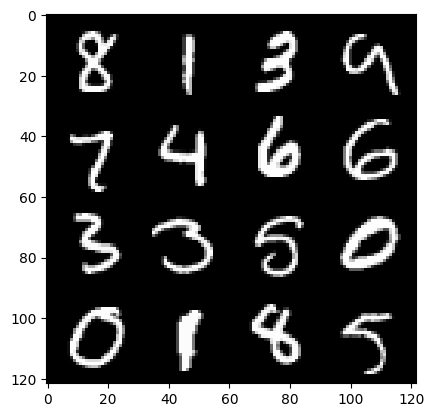

35: step 16800/ Generator Loss: 6.221840375264491 / disc_loss: 0.012141492560816303


  0%|          | 0/469 [00:00<?, ?it/s]

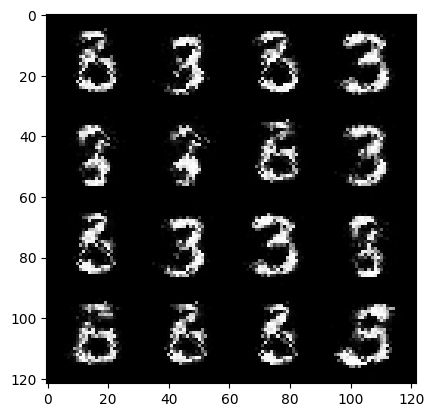

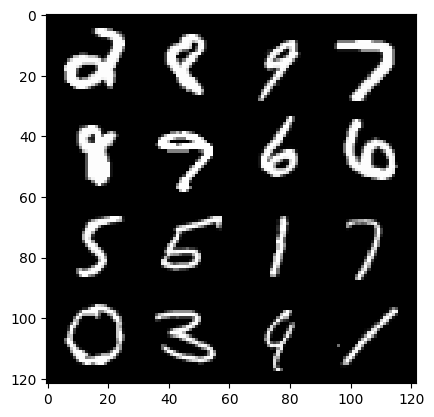

36: step 17100/ Generator Loss: 6.24916634082794 / disc_loss: 0.013682090187600499


  0%|          | 0/469 [00:00<?, ?it/s]

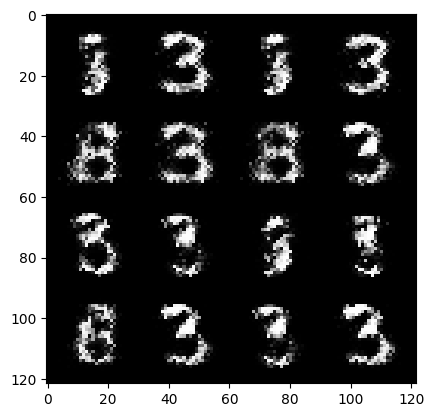

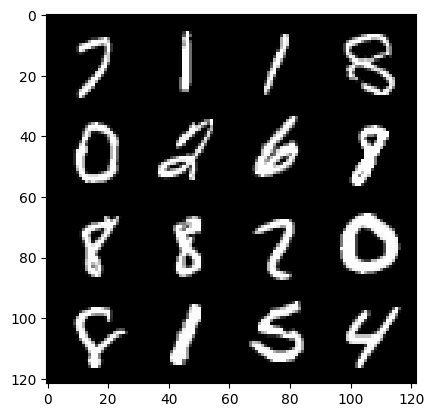

37: step 17400/ Generator Loss: 6.530278828938807 / disc_loss: 0.017562673046098397


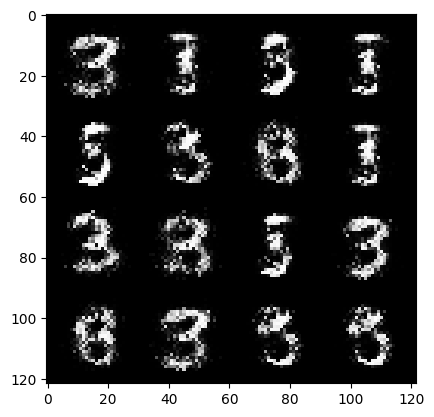

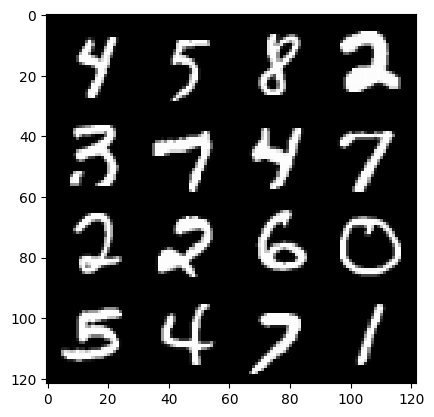

37: step 17700/ Generator Loss: 6.644867418607082 / disc_loss: 0.014154676181885109


  0%|          | 0/469 [00:00<?, ?it/s]

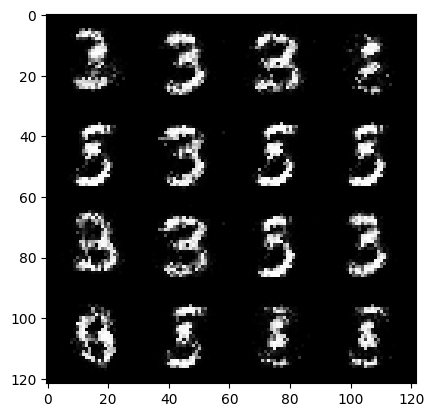

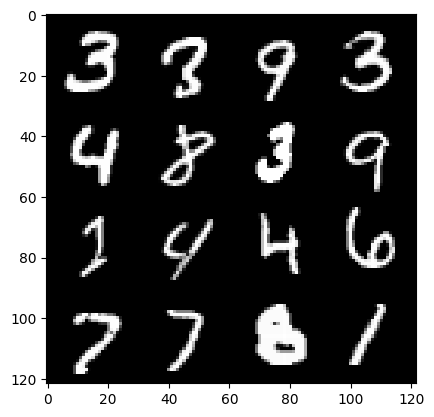

38: step 18000/ Generator Loss: 7.383020127614341 / disc_loss: 0.015109832733869554


  0%|          | 0/469 [00:00<?, ?it/s]

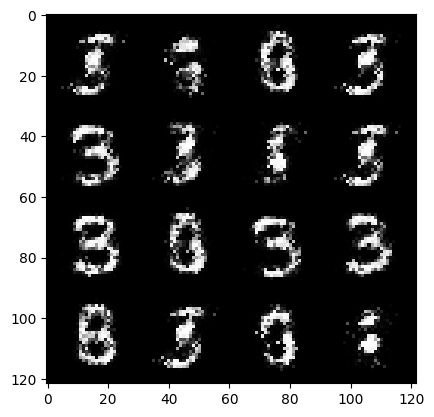

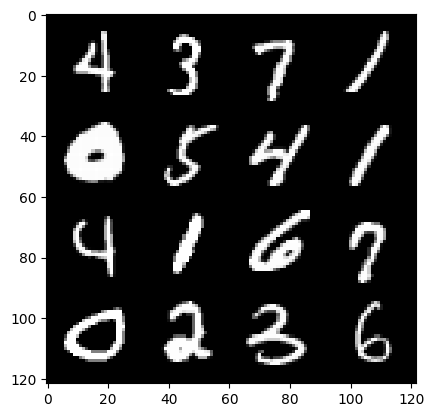

39: step 18300/ Generator Loss: 6.439610164960222 / disc_loss: 0.020629281350411484


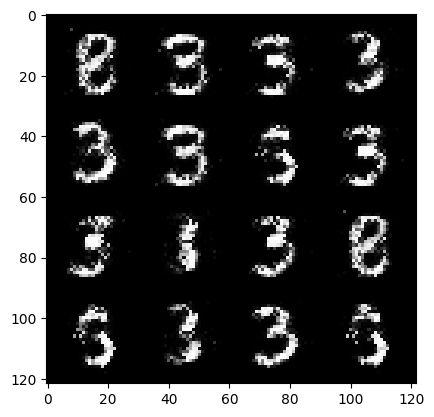

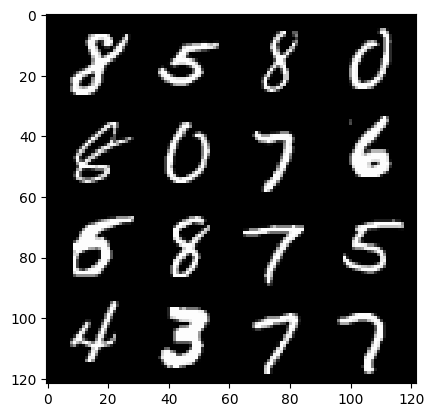

39: step 18600/ Generator Loss: 6.196583546002706 / disc_loss: 0.017886648752416166


  0%|          | 0/469 [00:00<?, ?it/s]

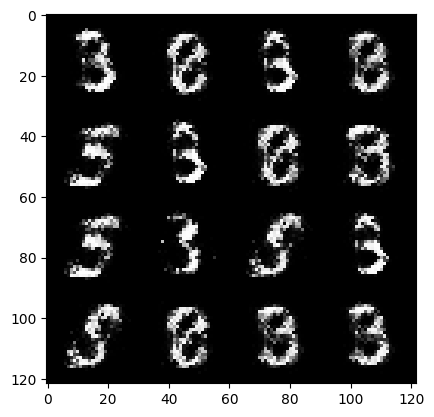

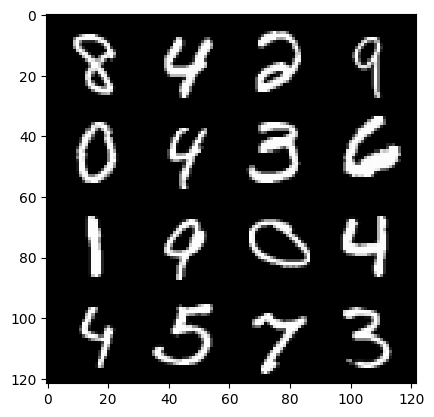

40: step 18900/ Generator Loss: 6.474947926203409 / disc_loss: 0.02170927944360301


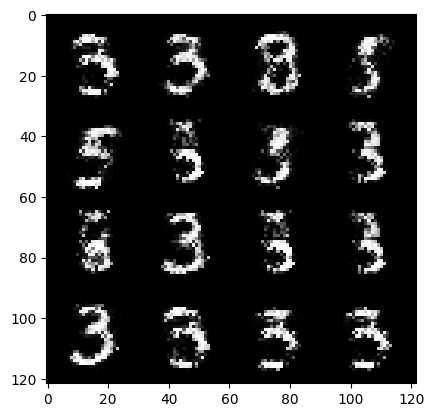

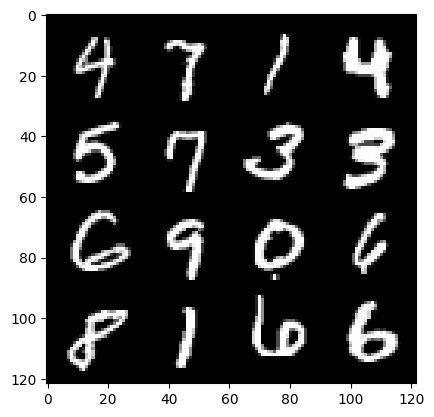

40: step 19200/ Generator Loss: 5.946772435506185 / disc_loss: 0.029700571141050503


  0%|          | 0/469 [00:00<?, ?it/s]

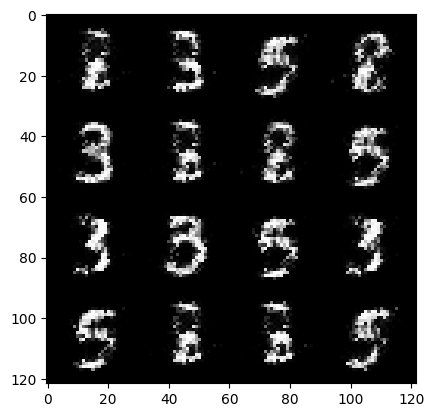

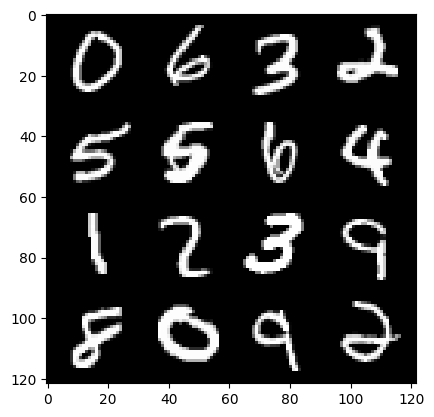

41: step 19500/ Generator Loss: 6.062860220273341 / disc_loss: 0.027427829172617466


  0%|          | 0/469 [00:00<?, ?it/s]

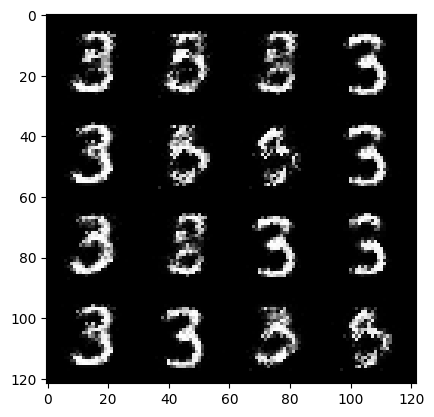

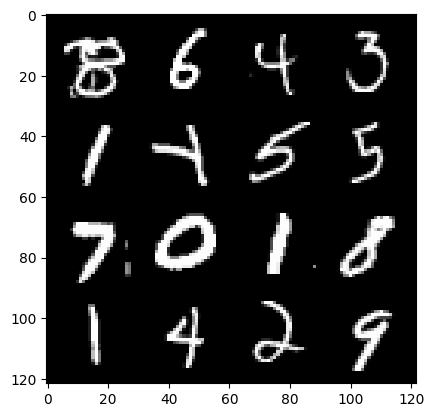

42: step 19800/ Generator Loss: 6.0866111930211435 / disc_loss: 0.02674780650374791


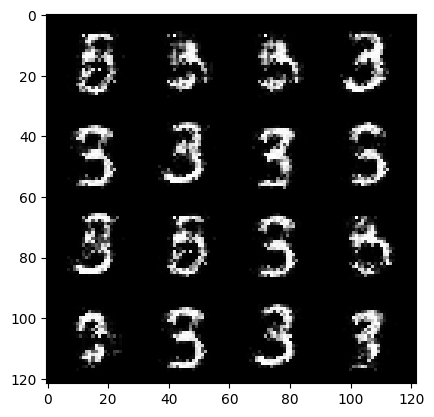

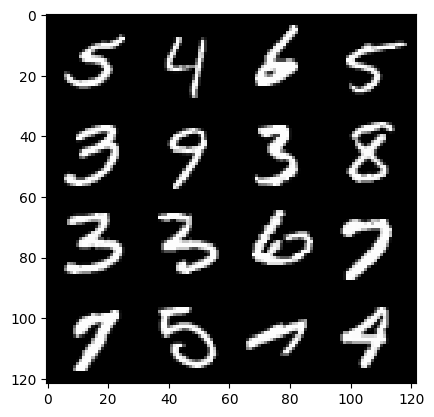

42: step 20100/ Generator Loss: 5.610961068471272 / disc_loss: 0.03222438001384338


  0%|          | 0/469 [00:00<?, ?it/s]

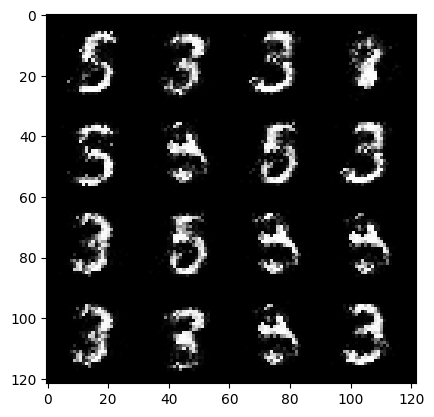

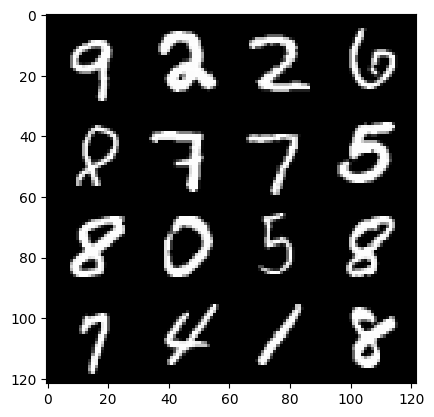

43: step 20400/ Generator Loss: 6.012462878227238 / disc_loss: 0.030558524203176302


  0%|          | 0/469 [00:00<?, ?it/s]

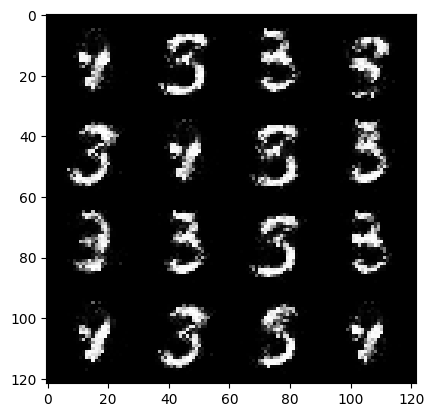

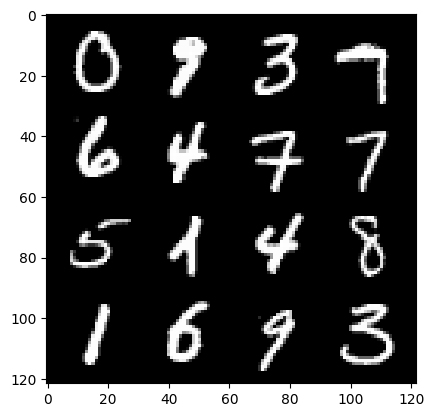

44: step 20700/ Generator Loss: 6.090885785420734 / disc_loss: 0.03215914626450589


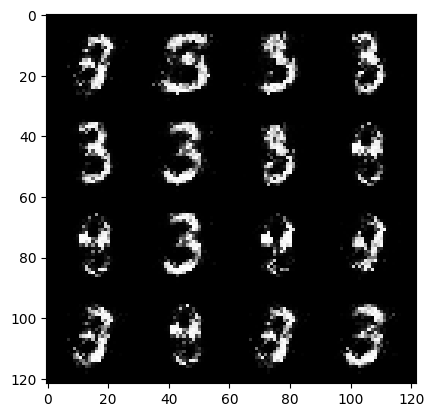

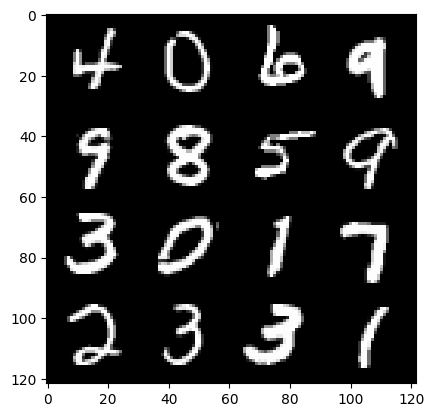

44: step 21000/ Generator Loss: 5.8192702579498246 / disc_loss: 0.03151348699349912


  0%|          | 0/469 [00:00<?, ?it/s]

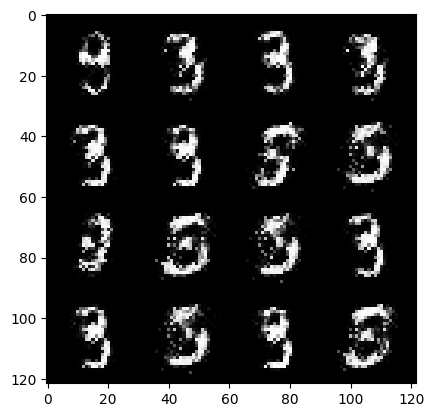

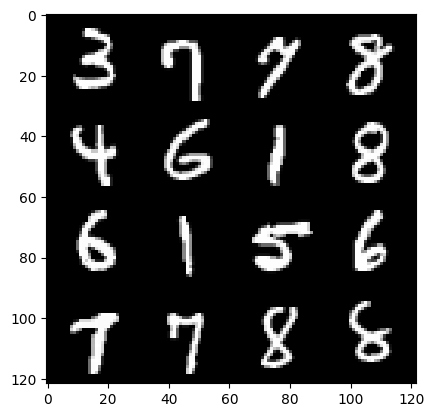

45: step 21300/ Generator Loss: 5.888336405754088 / disc_loss: 0.029047678705925756


  0%|          | 0/469 [00:00<?, ?it/s]

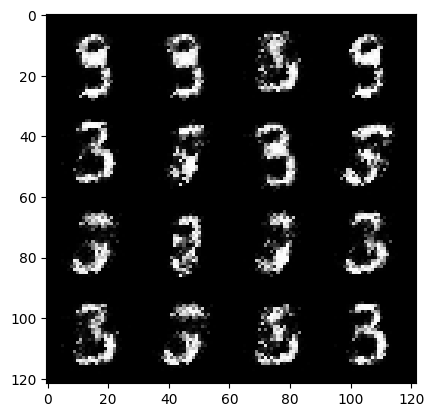

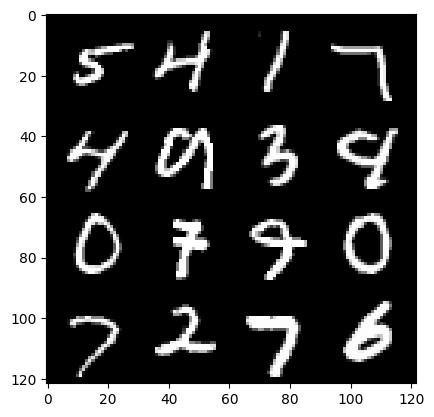

46: step 21600/ Generator Loss: 6.049190624554949 / disc_loss: 0.027974424034667492


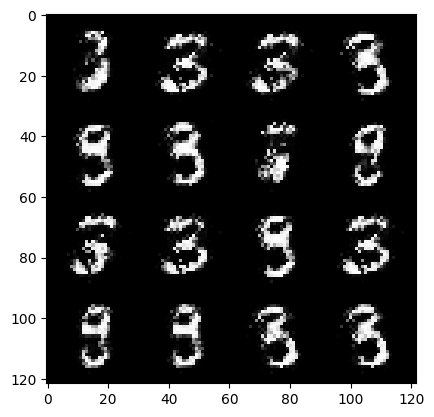

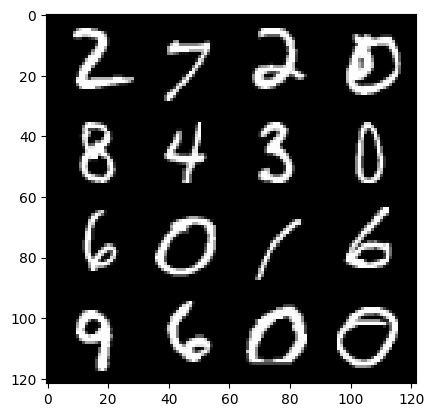

46: step 21900/ Generator Loss: 6.526349585851029 / disc_loss: 0.032346294831174134


  0%|          | 0/469 [00:00<?, ?it/s]

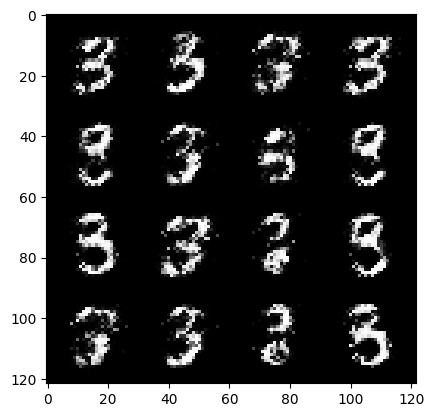

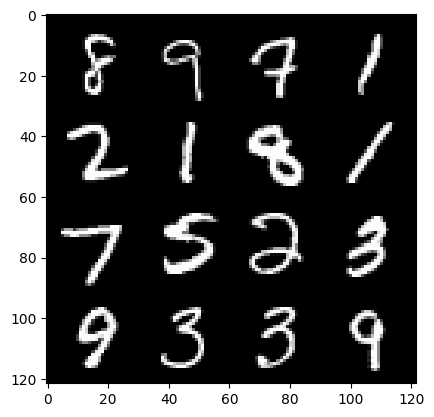

47: step 22200/ Generator Loss: 6.286226765314739 / disc_loss: 0.0320367442490533


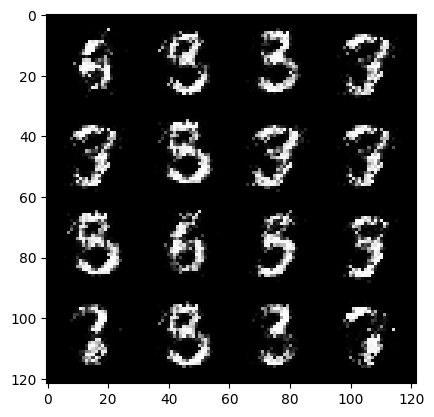

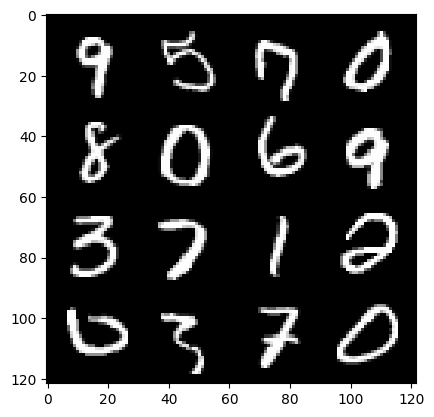

47: step 22500/ Generator Loss: 6.20704412937164 / disc_loss: 0.03530922200065104


  0%|          | 0/469 [00:00<?, ?it/s]

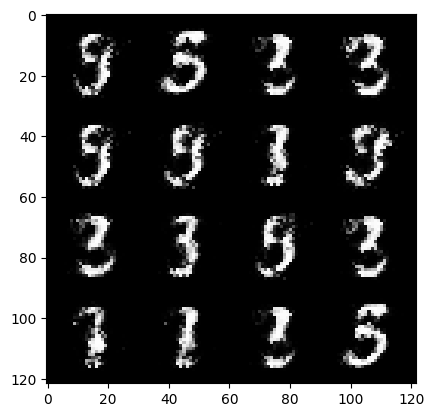

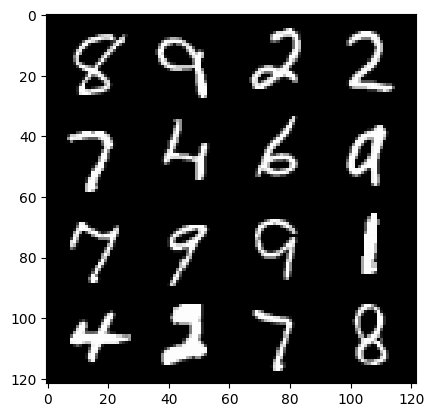

48: step 22800/ Generator Loss: 6.275094537734984 / disc_loss: 0.03314922895437726


  0%|          | 0/469 [00:00<?, ?it/s]

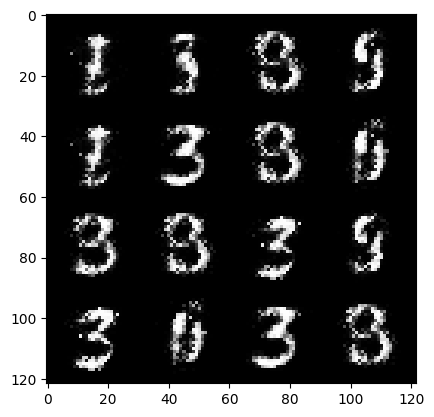

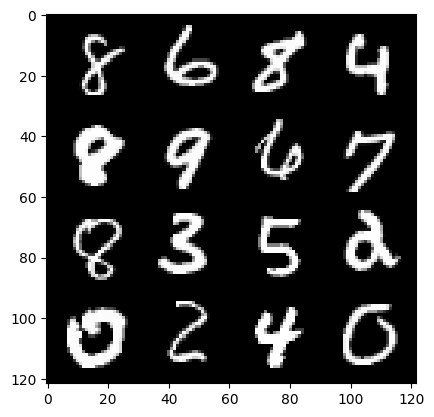

49: step 23100/ Generator Loss: 5.84676242510478 / disc_loss: 0.03125661263552807


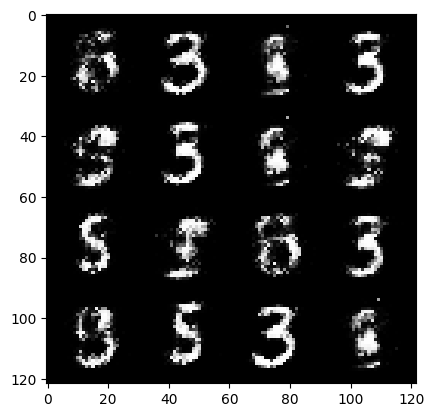

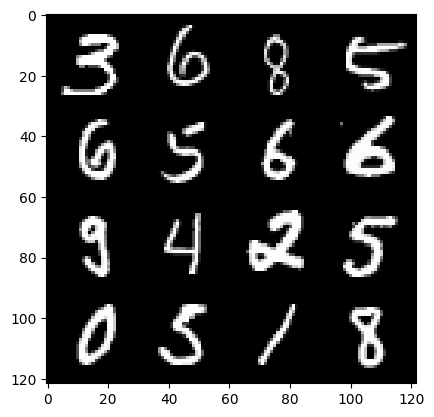

49: step 23400/ Generator Loss: 5.737621461550394 / disc_loss: 0.035006936262361704


  0%|          | 0/469 [00:00<?, ?it/s]

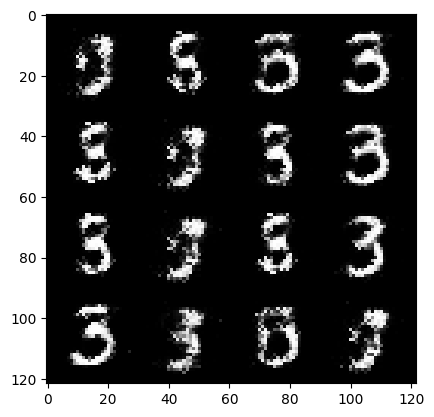

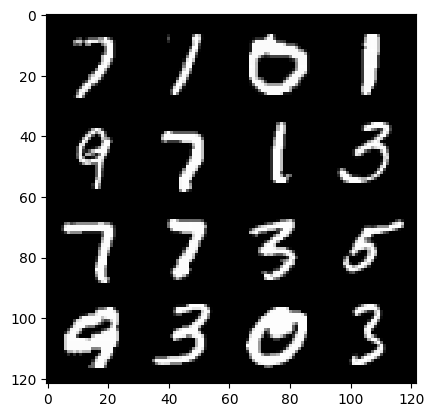

50: step 23700/ Generator Loss: 5.614716753959654 / disc_loss: 0.03815726196393372


  0%|          | 0/469 [00:00<?, ?it/s]

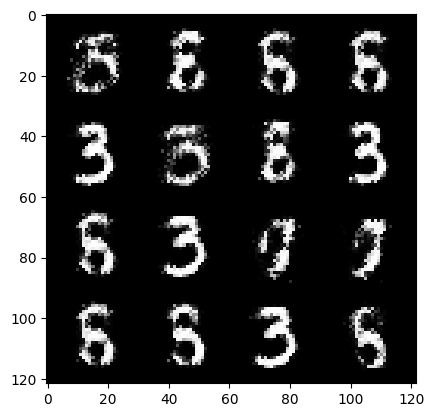

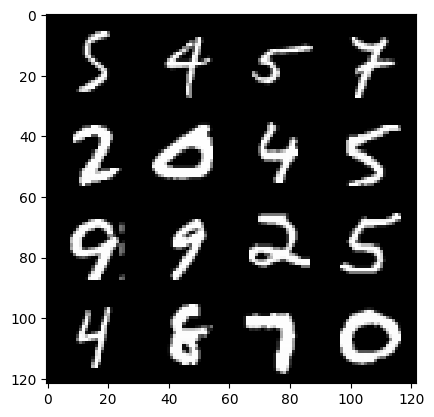

51: step 24000/ Generator Loss: 6.207440225283307 / disc_loss: 0.03908441950567066


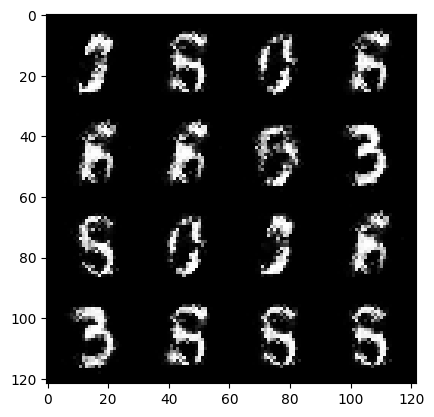

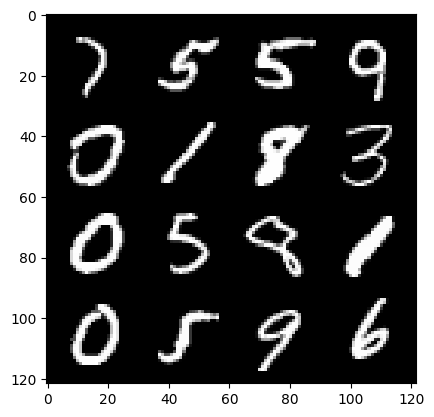

51: step 24300/ Generator Loss: 5.644721864064536 / disc_loss: 0.03929275790229437


  0%|          | 0/469 [00:00<?, ?it/s]

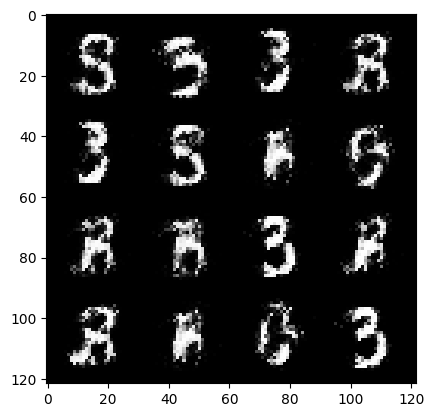

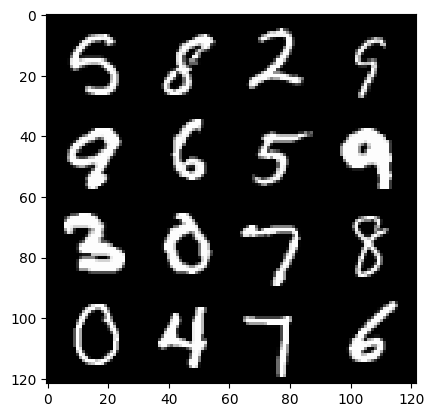

52: step 24600/ Generator Loss: 5.750462342898055 / disc_loss: 0.039896923634223654


  0%|          | 0/469 [00:00<?, ?it/s]

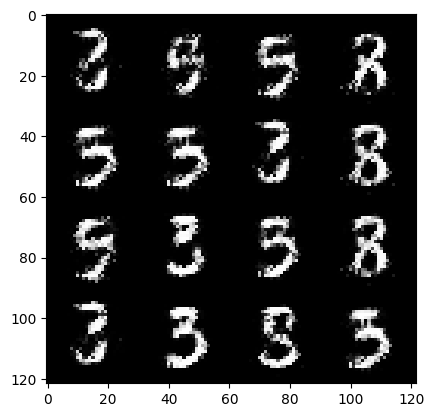

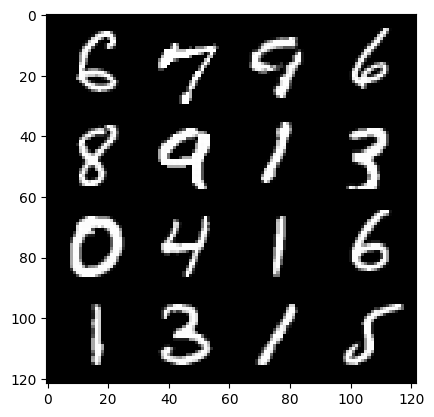

53: step 24900/ Generator Loss: 6.058865032196047 / disc_loss: 0.032486314992420384


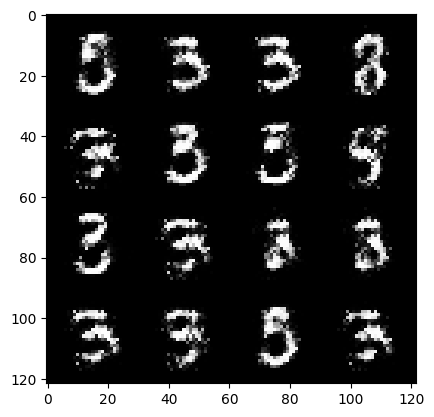

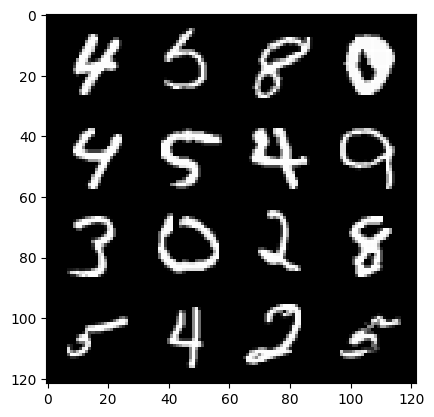

53: step 25200/ Generator Loss: 5.567892521222436 / disc_loss: 0.03191962755440424


  0%|          | 0/469 [00:00<?, ?it/s]

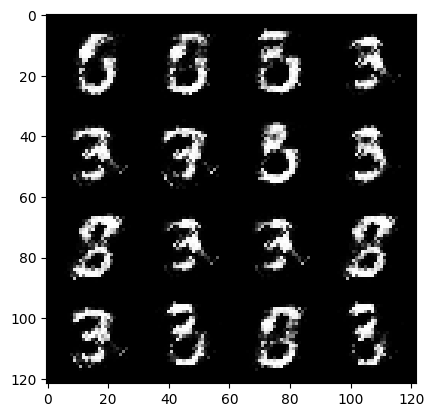

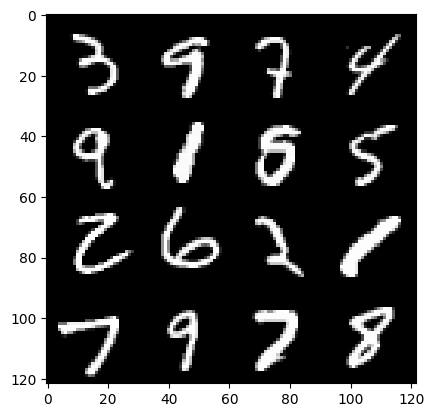

54: step 25500/ Generator Loss: 5.709827133814495 / disc_loss: 0.02929109992769858


  0%|          | 0/469 [00:00<?, ?it/s]

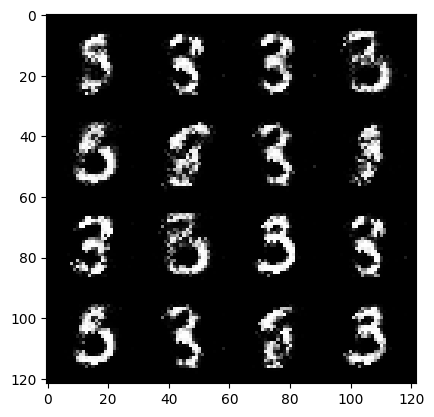

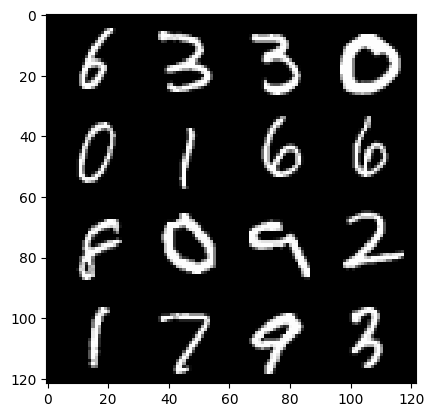

55: step 25800/ Generator Loss: 5.862527069250745 / disc_loss: 0.03436549772430831


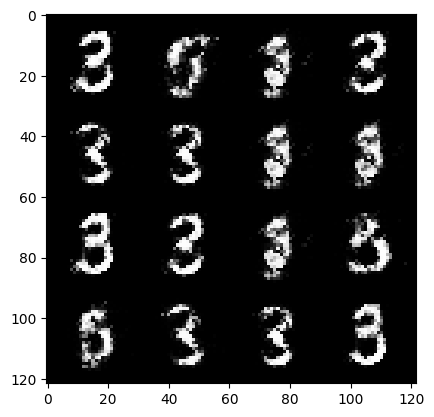

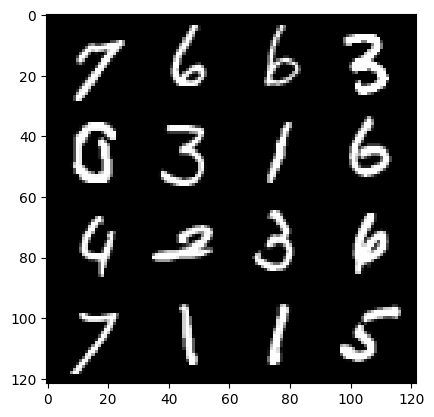

55: step 26100/ Generator Loss: 6.137759661674503 / disc_loss: 0.03567353211498507


  0%|          | 0/469 [00:00<?, ?it/s]

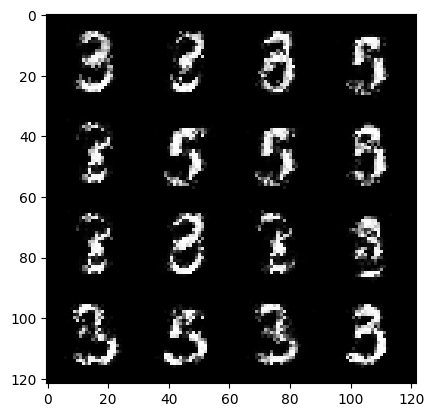

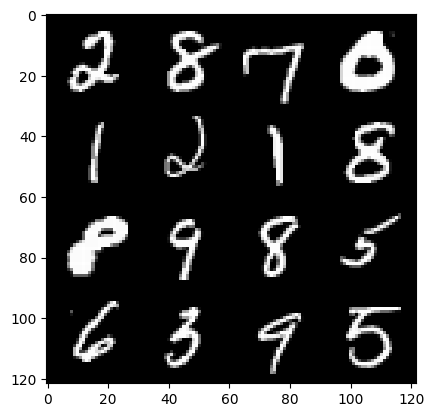

56: step 26400/ Generator Loss: 5.700777001380921 / disc_loss: 0.036231430581149957


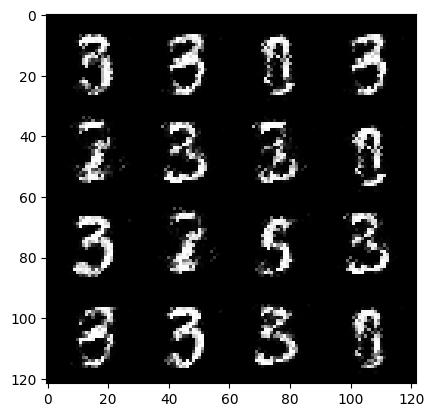

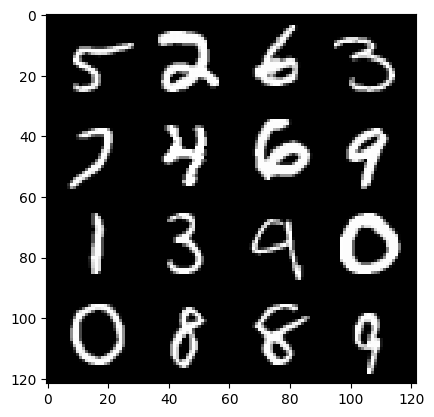

56: step 26700/ Generator Loss: 5.596149266560874 / disc_loss: 0.04829977564358462


  0%|          | 0/469 [00:00<?, ?it/s]

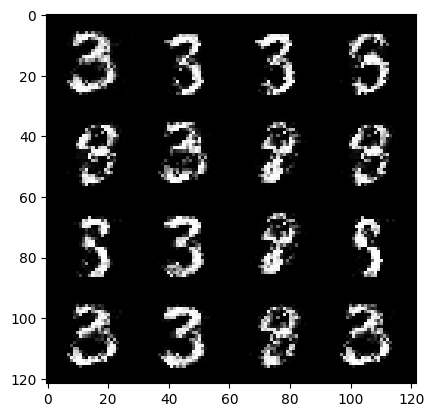

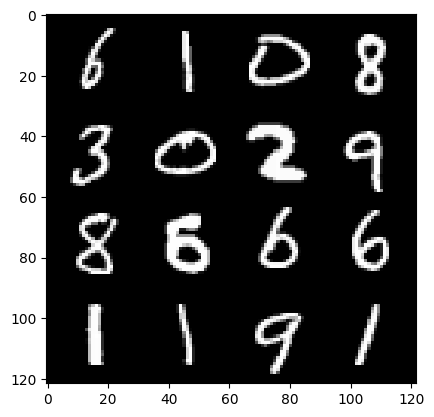

57: step 27000/ Generator Loss: 5.243944829305015 / disc_loss: 0.0447285473455364


  0%|          | 0/469 [00:00<?, ?it/s]

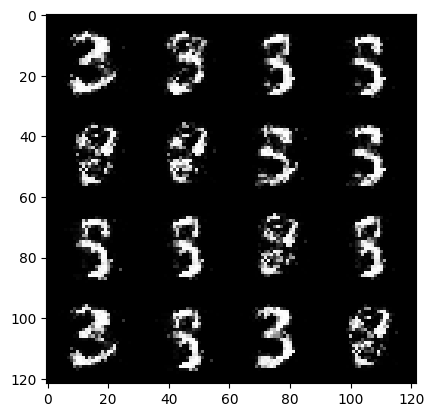

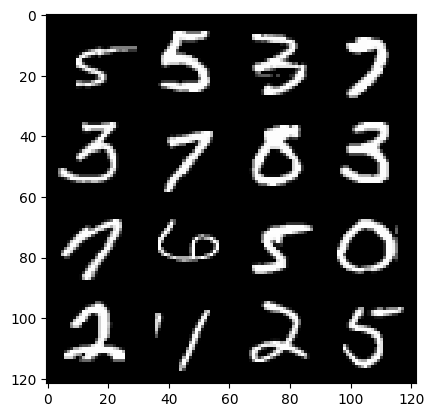

58: step 27300/ Generator Loss: 5.5014253838857 / disc_loss: 0.039883022912157055


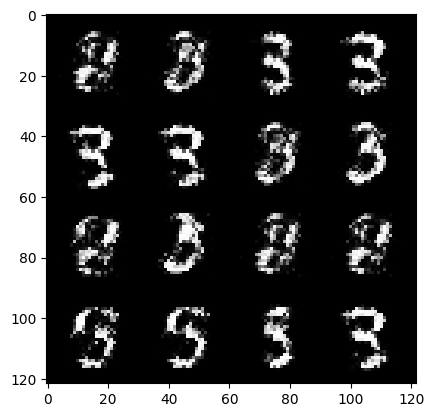

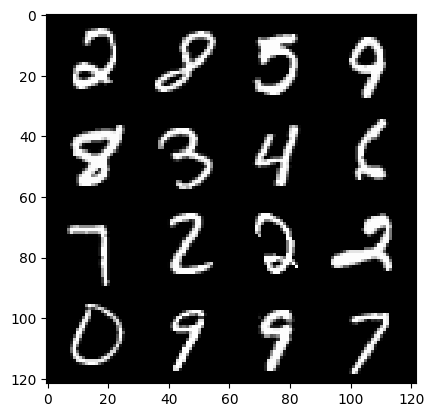

58: step 27600/ Generator Loss: 5.866364595095318 / disc_loss: 0.04707604959607126


  0%|          | 0/469 [00:00<?, ?it/s]

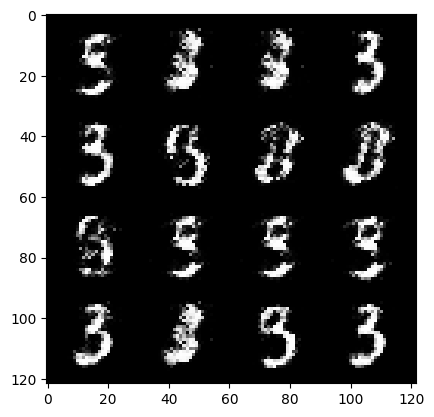

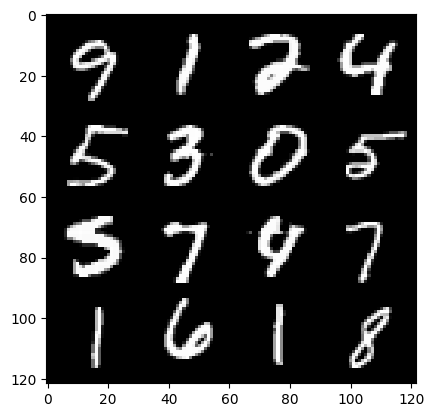

59: step 27900/ Generator Loss: 5.898500118255615 / disc_loss: 0.0434821620878453


  0%|          | 0/469 [00:00<?, ?it/s]

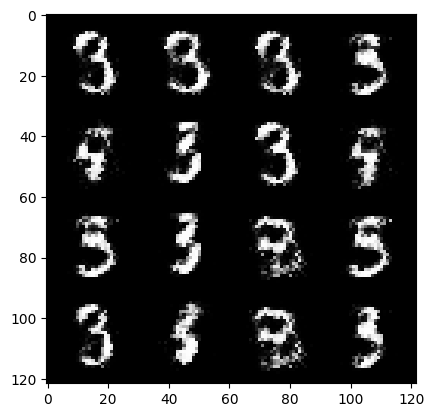

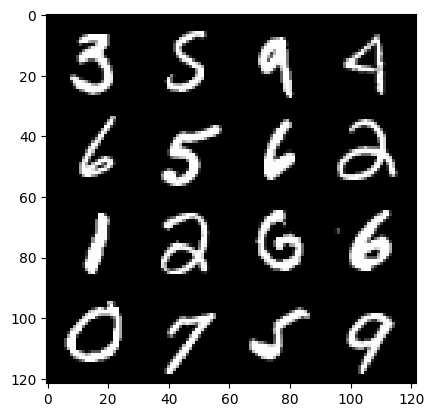

60: step 28200/ Generator Loss: 5.532064236005152 / disc_loss: 0.052240531939702746


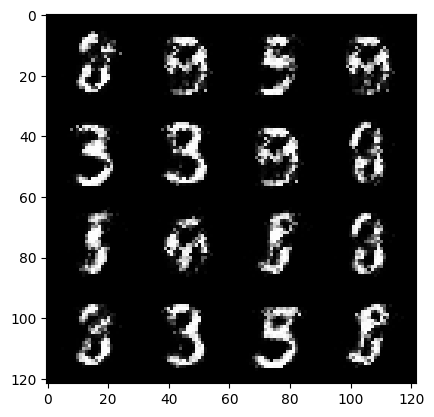

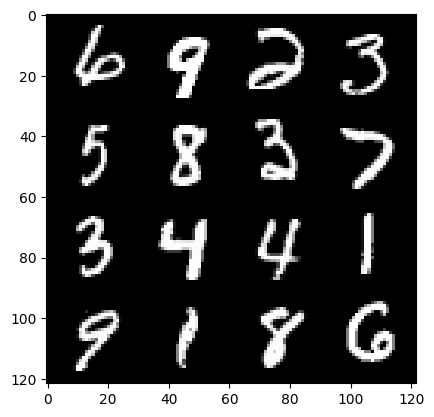

60: step 28500/ Generator Loss: 5.235745125611626 / disc_loss: 0.06081142014202972


  0%|          | 0/469 [00:00<?, ?it/s]

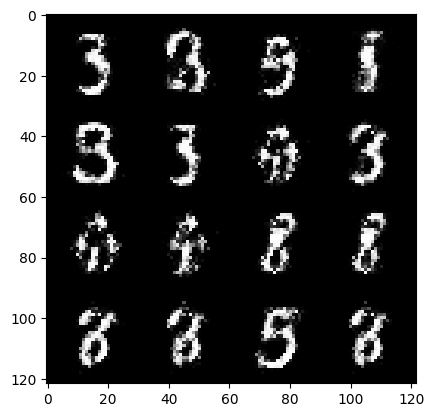

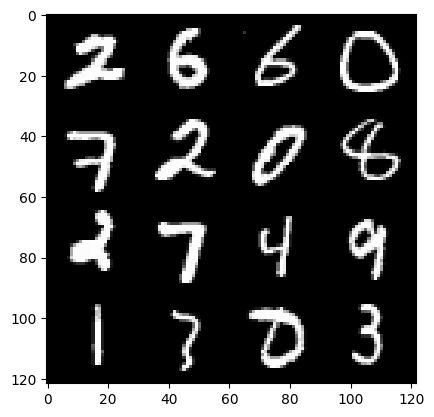

61: step 28800/ Generator Loss: 5.036760698159536 / disc_loss: 0.05144571905334787


  0%|          | 0/469 [00:00<?, ?it/s]

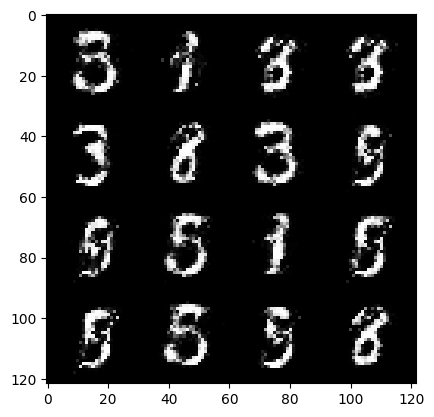

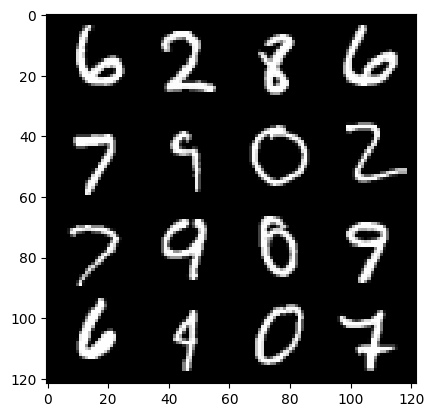

62: step 29100/ Generator Loss: 5.395717825889584 / disc_loss: 0.044866989971293764


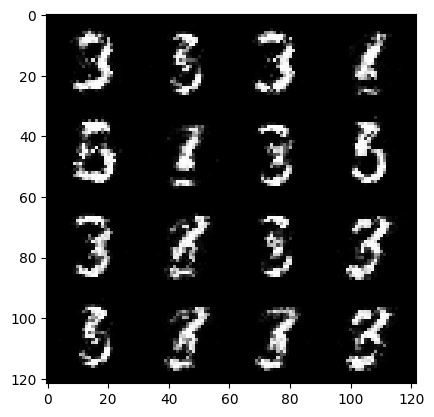

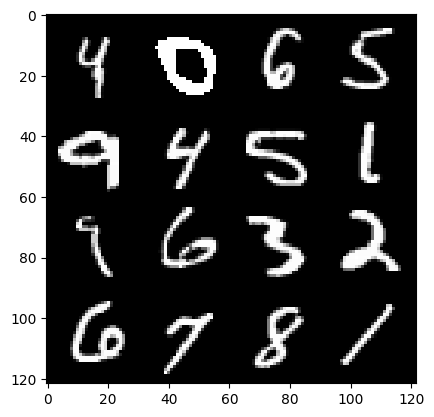

62: step 29400/ Generator Loss: 5.250741325219472 / disc_loss: 0.05647144817126293


  0%|          | 0/469 [00:00<?, ?it/s]

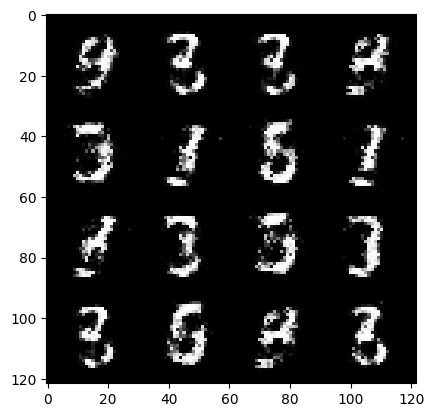

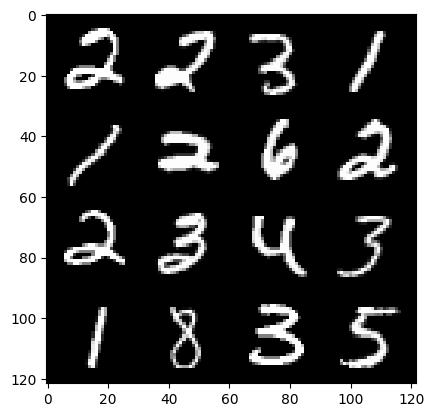

63: step 29700/ Generator Loss: 5.143002206484472 / disc_loss: 0.05836091127557062


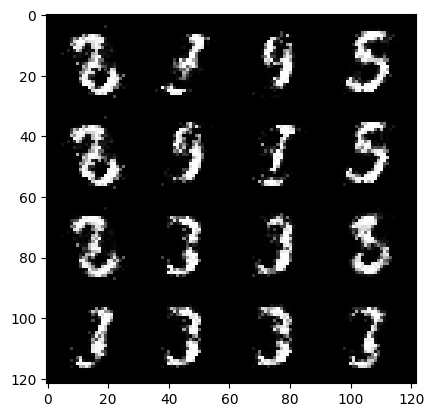

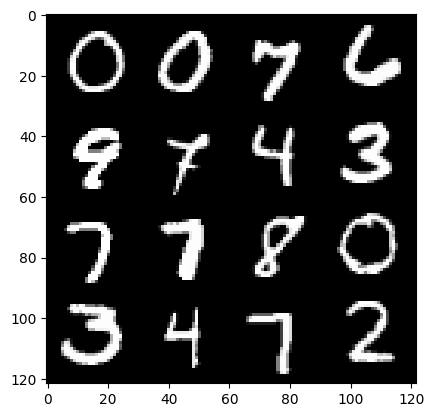

63: step 30000/ Generator Loss: 5.656421856880187 / disc_loss: 0.04917959284347796


  0%|          | 0/469 [00:00<?, ?it/s]

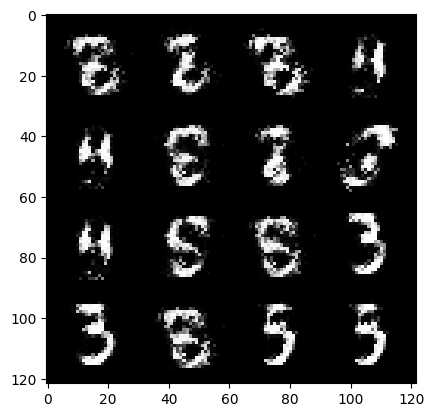

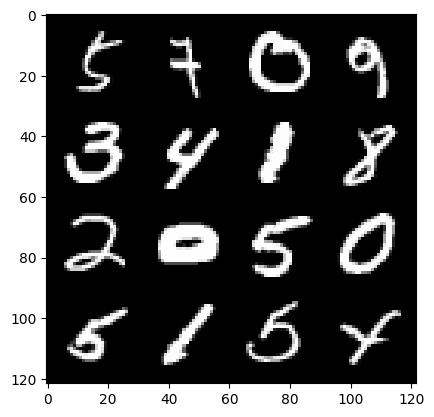

64: step 30300/ Generator Loss: 5.652442317008971 / disc_loss: 0.05055758744167791


  0%|          | 0/469 [00:00<?, ?it/s]

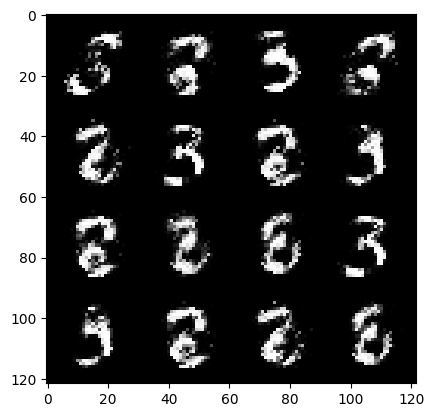

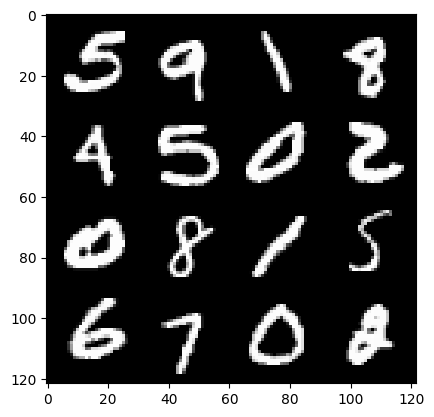

65: step 30600/ Generator Loss: 5.466752130190533 / disc_loss: 0.0479546329503258


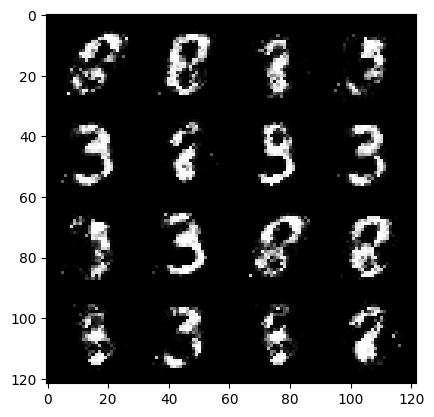

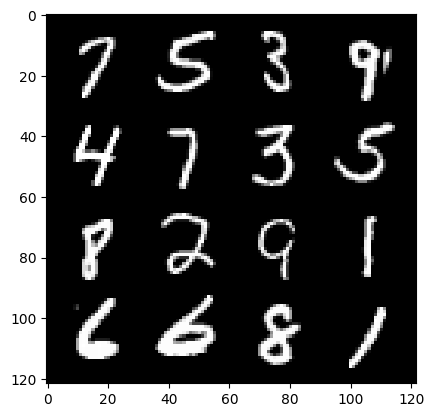

65: step 30900/ Generator Loss: 5.324829338391618 / disc_loss: 0.059606086310620116


  0%|          | 0/469 [00:00<?, ?it/s]

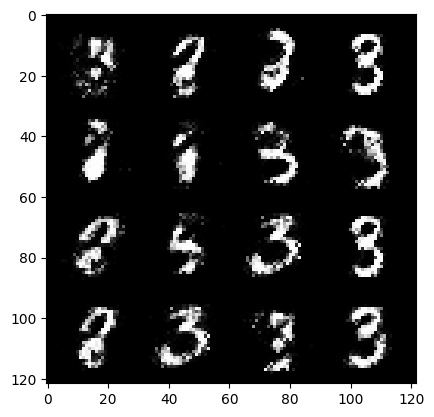

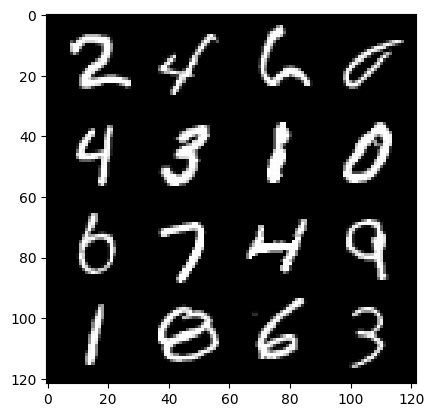

66: step 31200/ Generator Loss: 5.33111658414205 / disc_loss: 0.06148059906127553


  0%|          | 0/469 [00:00<?, ?it/s]

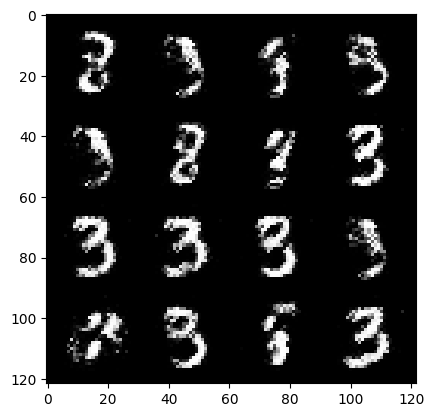

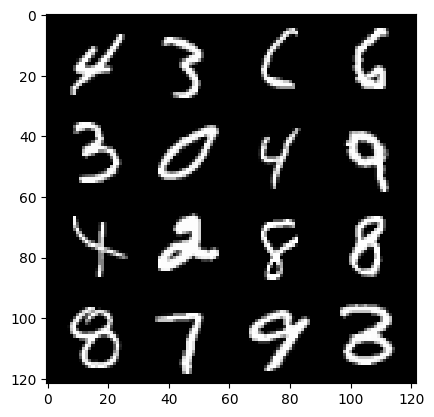

67: step 31500/ Generator Loss: 4.8769003272056555 / disc_loss: 0.0629955740024646


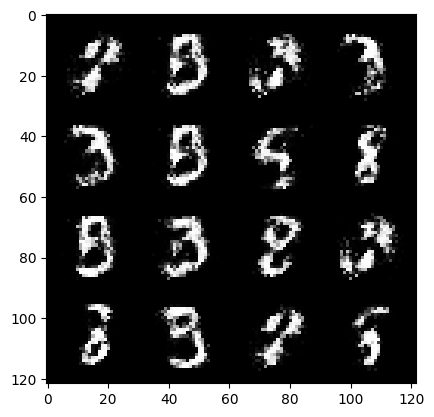

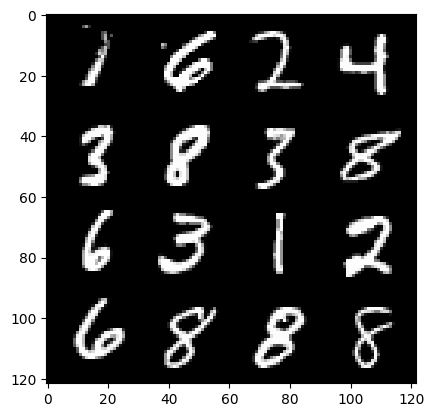

67: step 31800/ Generator Loss: 4.980948844750722 / disc_loss: 0.0648964742415895


  0%|          | 0/469 [00:00<?, ?it/s]

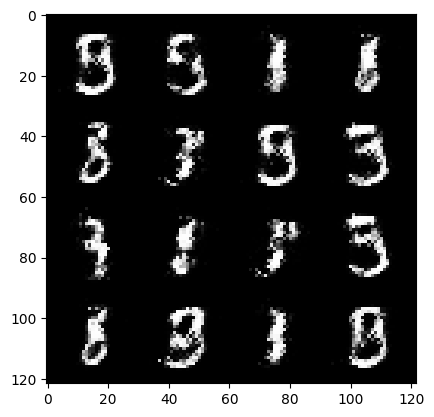

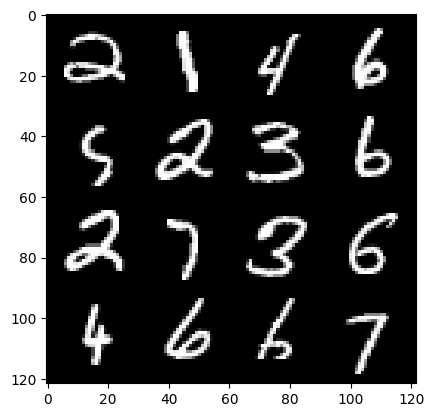

68: step 32100/ Generator Loss: 4.732621661822007 / disc_loss: 0.06355718031525613


  0%|          | 0/469 [00:00<?, ?it/s]

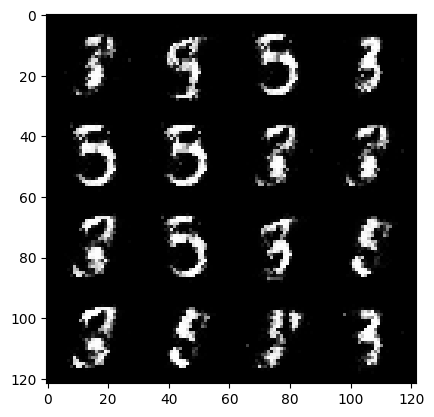

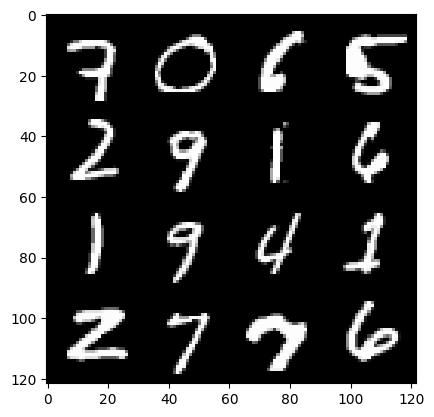

69: step 32400/ Generator Loss: 4.867233496507012 / disc_loss: 0.06049407999652125


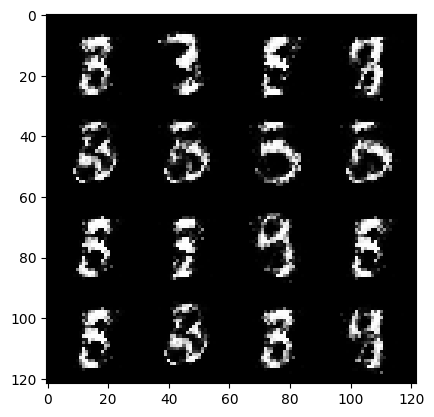

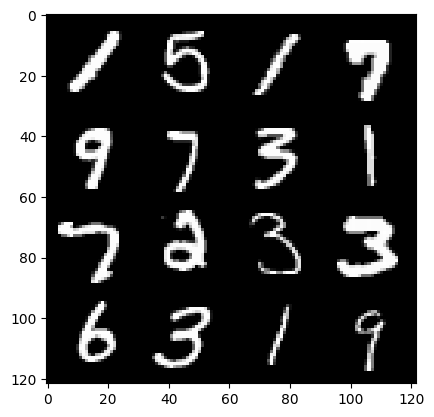

69: step 32700/ Generator Loss: 5.205173606872559 / disc_loss: 0.05866969327752789


  0%|          | 0/469 [00:00<?, ?it/s]

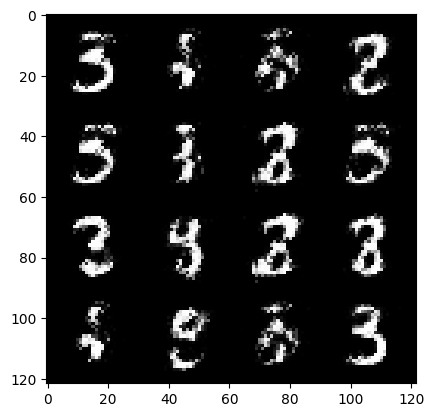

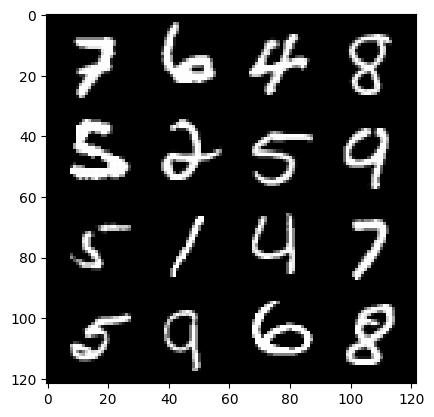

70: step 33000/ Generator Loss: 5.037580324808757 / disc_loss: 0.07245604493344822


  0%|          | 0/469 [00:00<?, ?it/s]

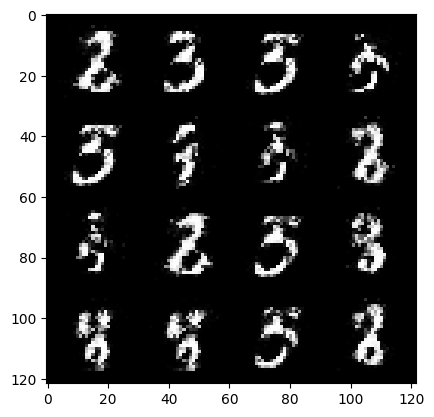

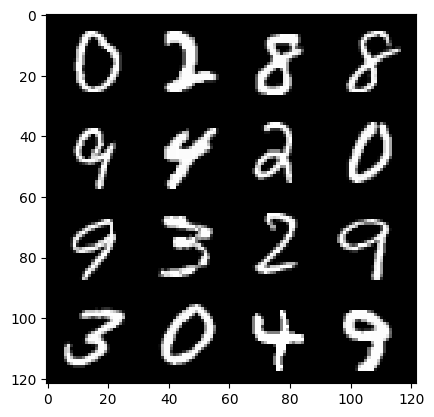

71: step 33300/ Generator Loss: 5.090127763748169 / disc_loss: 0.06442935305337112


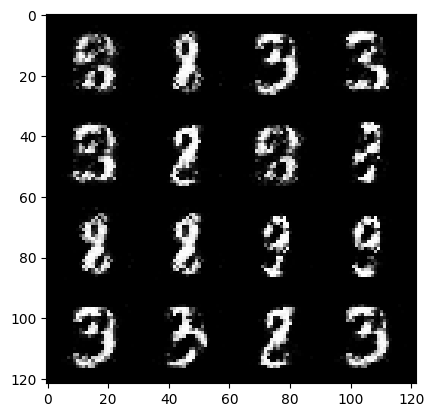

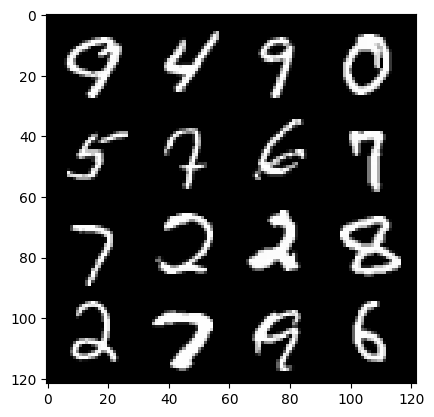

71: step 33600/ Generator Loss: 5.075680847962702 / disc_loss: 0.060116895406196504


  0%|          | 0/469 [00:00<?, ?it/s]

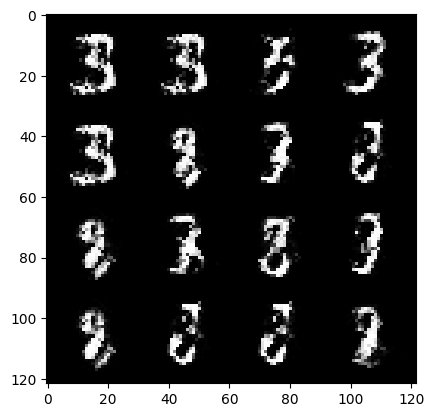

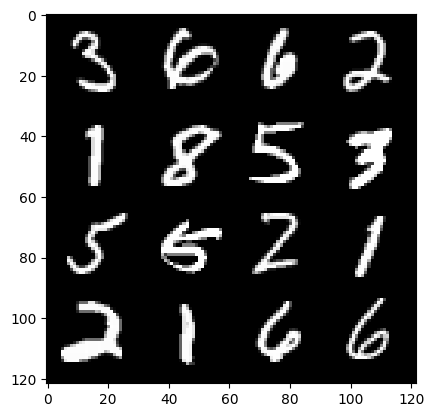

72: step 33900/ Generator Loss: 4.98870745976766 / disc_loss: 0.06734167788332954


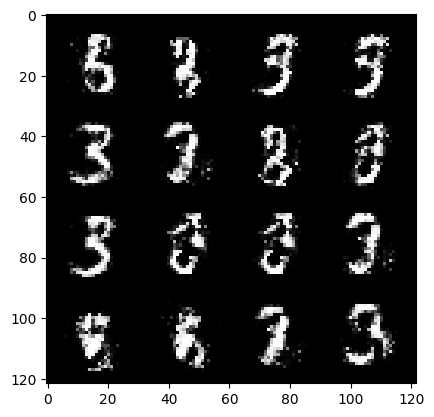

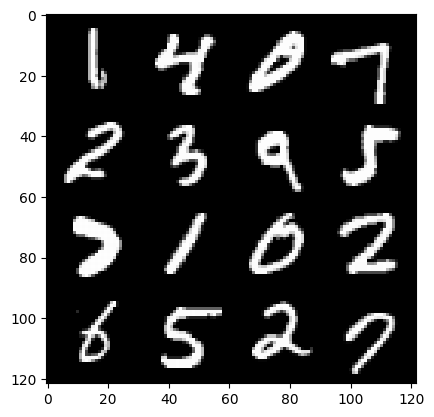

72: step 34200/ Generator Loss: 4.7156815751393655 / disc_loss: 0.07391153858043256


  0%|          | 0/469 [00:00<?, ?it/s]

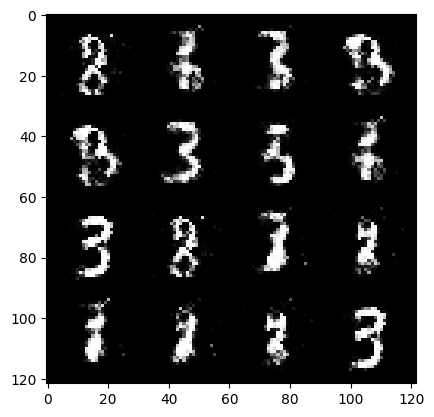

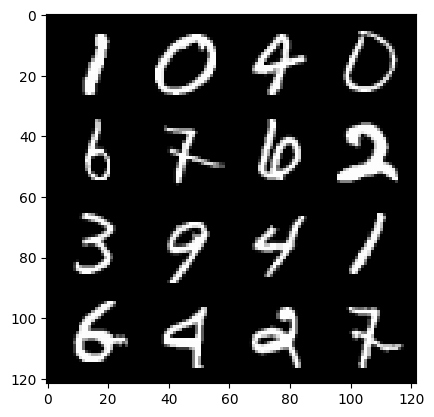

73: step 34500/ Generator Loss: 4.659822237491609 / disc_loss: 0.07271560150509082


  0%|          | 0/469 [00:00<?, ?it/s]

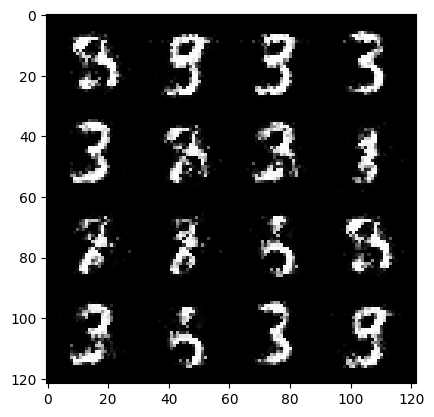

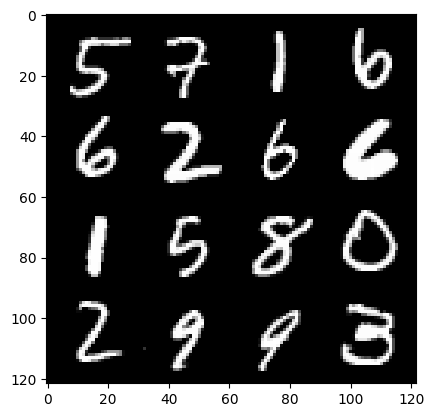

74: step 34800/ Generator Loss: 4.869557150204979 / disc_loss: 0.051975567527115366


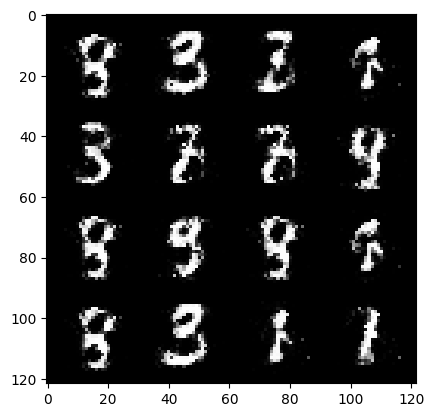

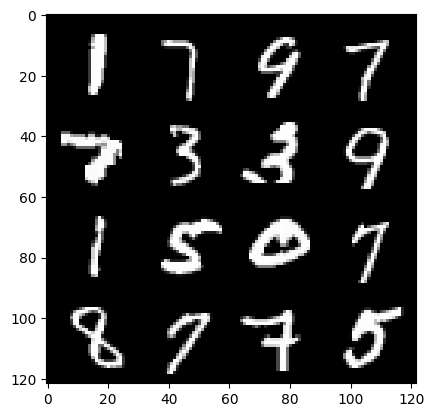

74: step 35100/ Generator Loss: 5.026180664698284 / disc_loss: 0.05740094951974843


  0%|          | 0/469 [00:00<?, ?it/s]

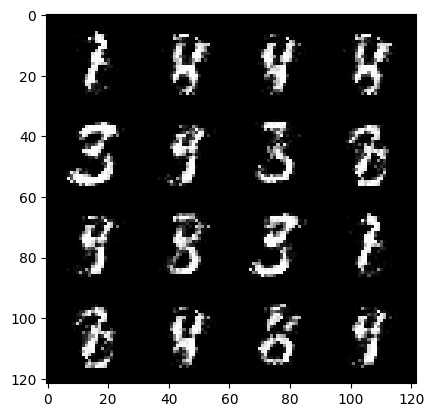

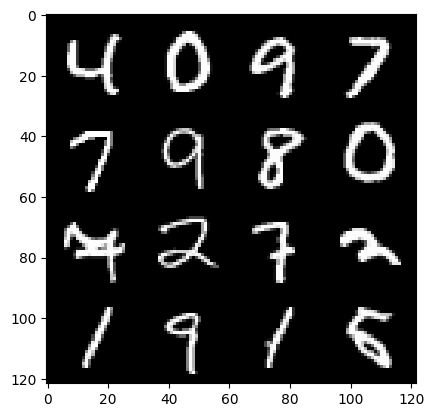

75: step 35400/ Generator Loss: 4.832619392077129 / disc_loss: 0.06404317675779261


  0%|          | 0/469 [00:00<?, ?it/s]

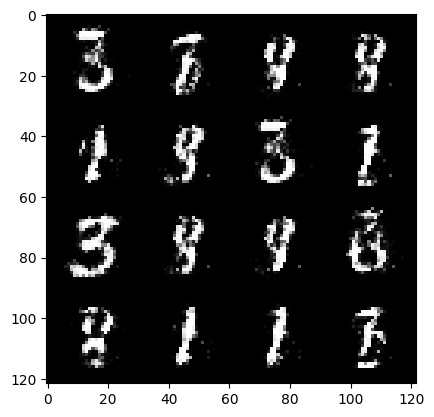

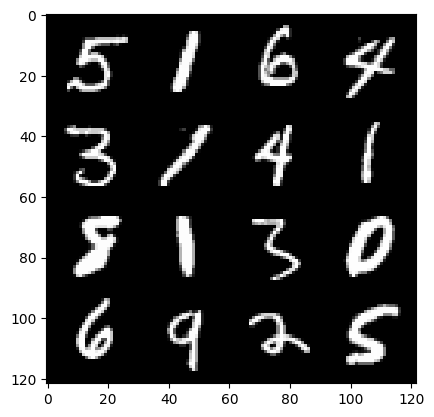

76: step 35700/ Generator Loss: 4.672958582242332 / disc_loss: 0.06411371136705087


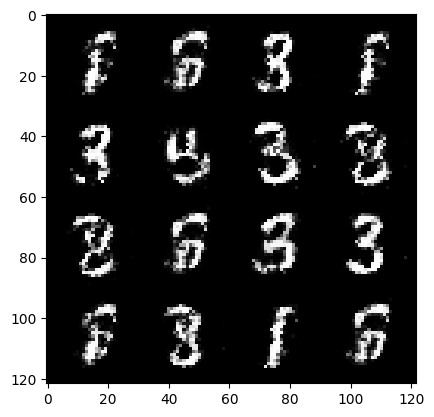

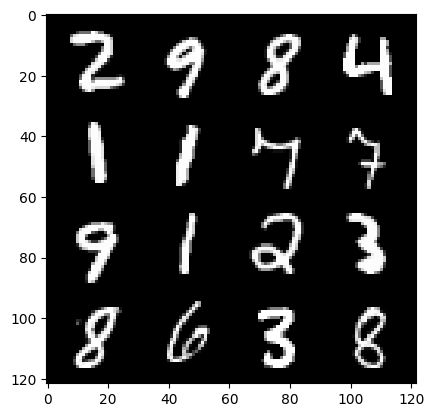

76: step 36000/ Generator Loss: 4.792814779281615 / disc_loss: 0.06376718847391509


  0%|          | 0/469 [00:00<?, ?it/s]

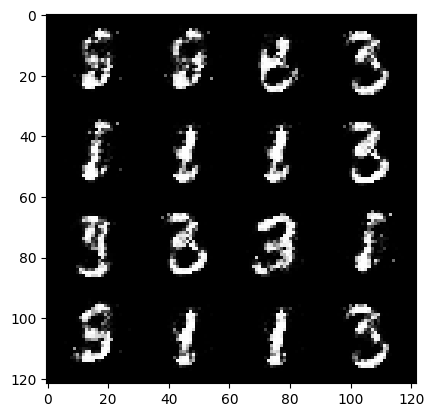

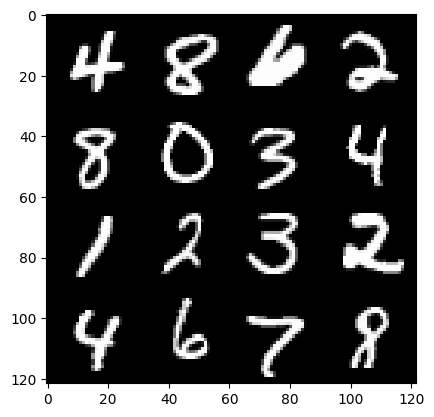

77: step 36300/ Generator Loss: 4.573135414918264 / disc_loss: 0.07628968627502525


  0%|          | 0/469 [00:00<?, ?it/s]

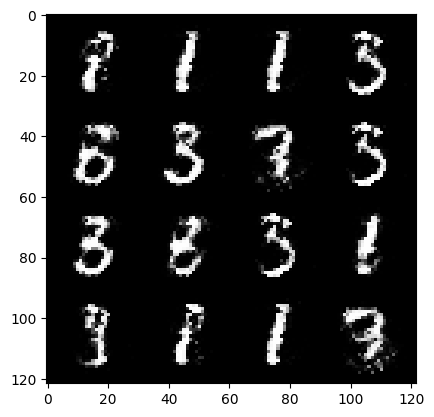

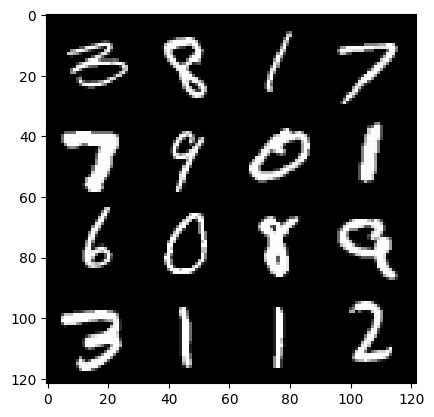

78: step 36600/ Generator Loss: 4.489544058640796 / disc_loss: 0.06984847530722615


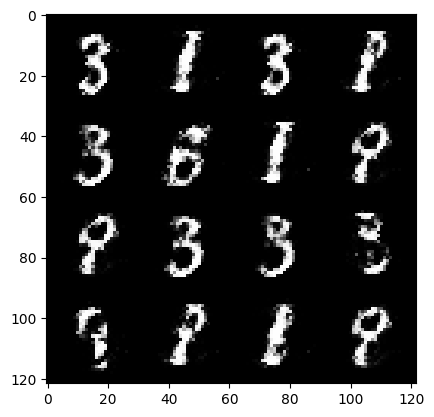

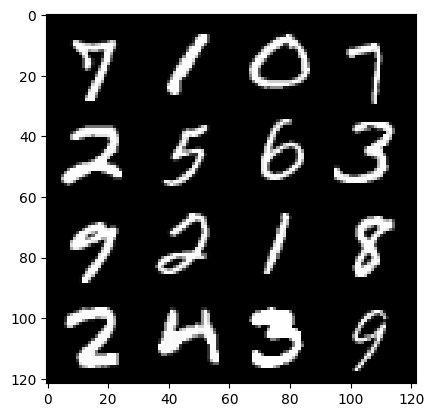

78: step 36900/ Generator Loss: 4.575572909514109 / disc_loss: 0.08724567623188097


  0%|          | 0/469 [00:00<?, ?it/s]

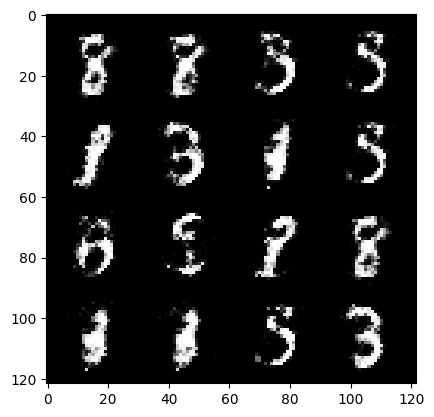

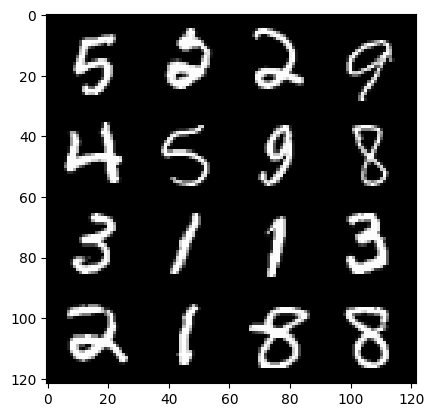

79: step 37200/ Generator Loss: 4.459285342693326 / disc_loss: 0.08635251732543116


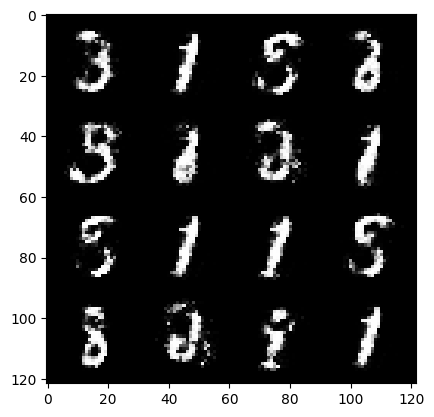

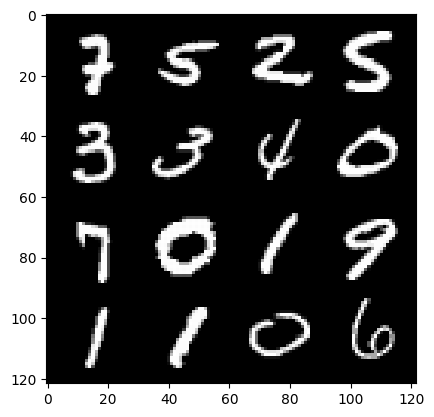

79: step 37500/ Generator Loss: 4.768477617899577 / disc_loss: 0.0689344839130839


  0%|          | 0/469 [00:00<?, ?it/s]

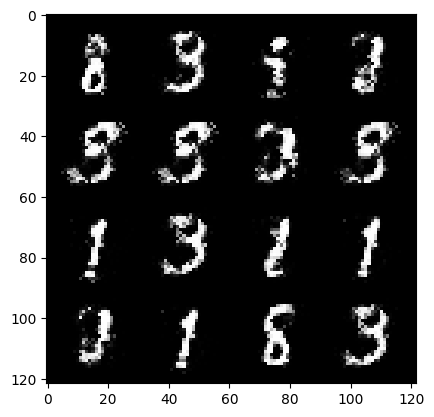

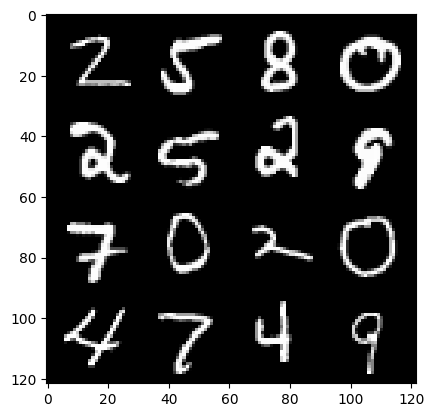

80: step 37800/ Generator Loss: 4.6576253445943205 / disc_loss: 0.06667619774738948


  0%|          | 0/469 [00:00<?, ?it/s]

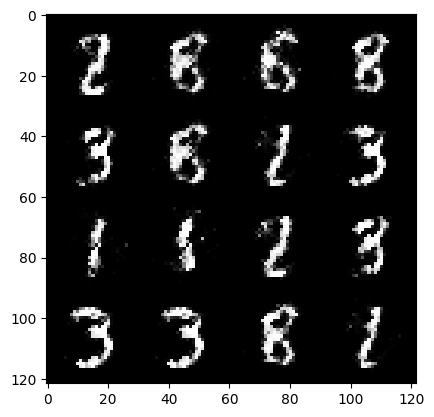

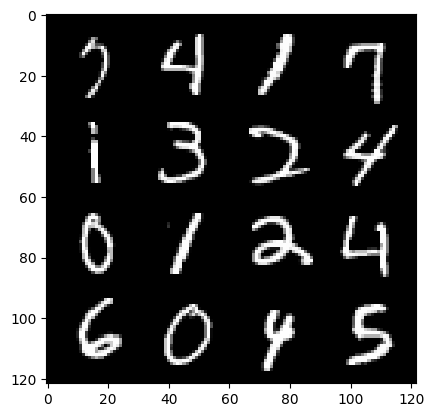

81: step 38100/ Generator Loss: 4.540059767564136 / disc_loss: 0.08063488159949586


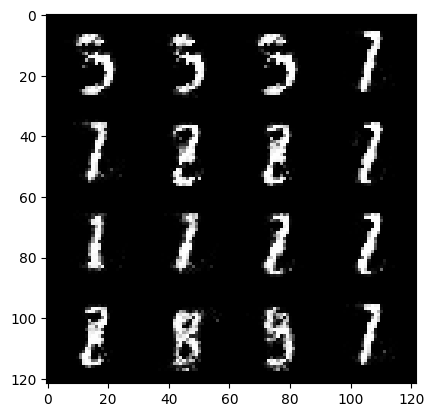

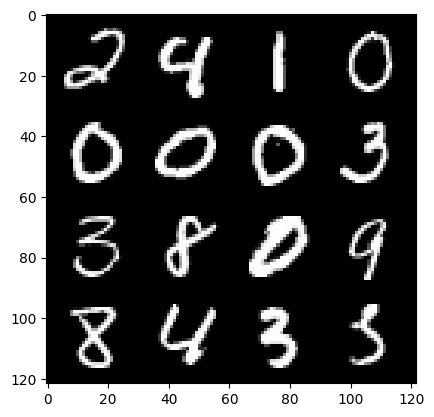

81: step 38400/ Generator Loss: 4.246869821548462 / disc_loss: 0.10281380259742343


  0%|          | 0/469 [00:00<?, ?it/s]

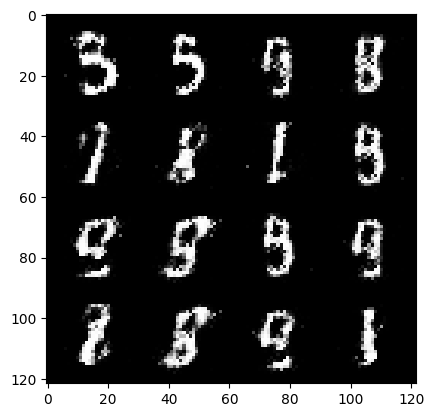

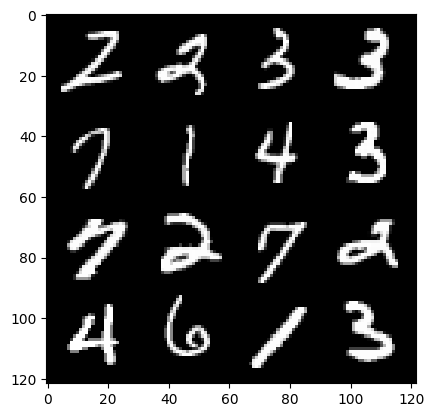

82: step 38700/ Generator Loss: 4.54414911826452 / disc_loss: 0.09185006076470016


In [ ]:
# Training loop
### 6000 / 128 = 468.75 = 469 steps in each epoch
### Each step is going to process 128 images - size of the batch (except the last step)


for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ## discriminator
    disc_opt.zero_grad()
    cur_bs = len(real)
    real =  real.view(cur_bs, -1)
    real = real.to(device)
    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph = True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss += disc_loss.item()/info_step
    mean_gen_loss += gen_loss.item()/info_step


    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step}/ Generator Loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1